## **Lab 2 | Handwritten Digit Recognition System**

Problem Statement
- Developing a handwritten digital recognition system by creating a neural network model trained on MNIST dataset "handwritten digits from 0 to 9"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Step 1: [Loading MNIST dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)**

In [35]:
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

print(train_data.head())

print("\nTrain Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)


**Dataset description:**
 - The MNIST dataset contains grayscale images of digits along with their corresponding labels.
 - Each image is 28x28 pixels, flattened into a vector of size 784.
 - The labels range from 0 to 9.

#### *Checking dataset distribution*

In [ ]:
print("\nTrain Data Distribution:")
print(train_data.iloc[:, 0].value_counts())

print("\nTest Data Distribution:")
print(test_data.iloc[:, 0].value_counts())


Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)

Train Data Distribution:
label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

Test Data Distribution:
label
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64


**Conclusion**: the distribution is well balanced, no label is significantly overrepresented, or underrepresented, which minimizes bias towards a specific label

### **Step 2: Data Splitting**

In [5]:
X_temp = train_data.iloc[:,1:].values
y_temp = train_data.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=10000, stratify=y_temp, random_state=42)

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [6]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50000
Validation set size: 10000
Test set size: 10000


#### *Normalization*
 dividing by 255, so that ranges are [0,1], ensuring numerical stability during training

In [7]:
X_test = X_test / 255.0
X_train = X_train / 255.0
X_val = X_val / 255.0

Visual representation of a random sample

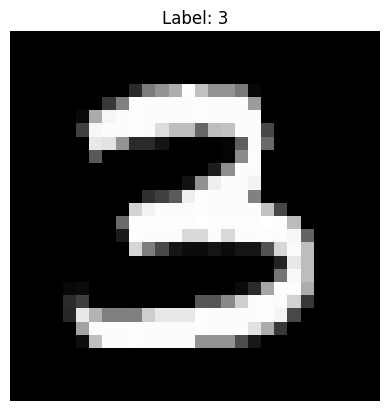

In [10]:
sample_image = X_train[10]
sample_label = y_train[10]
sample_image = sample_image.reshape(28, 28)

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

### **Step 3: Converting Data to Tensors**

In [11]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### **Step 4: Data Loaders** to facilitate batch processing

In [12]:
batch_size = 32

# Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Step 5: Neural Network Design**
Fully connected feedforward neural network with:
- Input layer: 784 neurons, one for each pixel
- 2 hidden layers: 128 neurons in the first, and 64 neurons in the second
- Output layer: 10 neurons, one for each class
- activation function: ReLU

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


- Loss function: Cross-Entropy Loss
- Optimization technique: Stochastic Gradient Descent (SGD)
- Learning Rate: 0.01

In [14]:
model = FeedforwardNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### **Step 6: Training the model**

In [15]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  for epoch in range(epochs):

      # Training Loss and Accuracy
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct / total

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation Loss and Accuracy
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      for inputs, labels in val_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

      val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * val_correct / val_total

      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{epochs}]')
      print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
      print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

  # Plot the training loss
  plt.figure(figsize=(12, 10))

  # Plot loss
  plt.subplot(2, 2, 1)  # Training Loss
  plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 2)  # Validation Loss
  plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
  plt.title('Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Plot accuracy
  plt.subplot(2, 2, 3)  # Training Accuracy
  plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  plt.subplot(2, 2, 4)  # Validation Accuracy
  plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
  plt.title('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  # Show the plots
  plt.tight_layout()
  plt.show()

Epoch [1/10]
Training Loss: 1.3262, Accuracy: 69.68%
Validation Loss: 0.4874, Accuracy: 86.52%
Epoch [2/10]
Training Loss: 0.3903, Accuracy: 88.87%
Validation Loss: 0.3415, Accuracy: 90.40%
Epoch [3/10]
Training Loss: 0.3123, Accuracy: 91.04%
Validation Loss: 0.2905, Accuracy: 91.83%
Epoch [4/10]
Training Loss: 0.2712, Accuracy: 92.25%
Validation Loss: 0.2566, Accuracy: 92.58%
Epoch [5/10]
Training Loss: 0.2405, Accuracy: 93.06%
Validation Loss: 0.2299, Accuracy: 93.50%
Epoch [6/10]
Training Loss: 0.2164, Accuracy: 93.81%
Validation Loss: 0.2081, Accuracy: 94.05%
Epoch [7/10]
Training Loss: 0.1952, Accuracy: 94.39%
Validation Loss: 0.1896, Accuracy: 94.59%
Epoch [8/10]
Training Loss: 0.1786, Accuracy: 94.80%
Validation Loss: 0.1740, Accuracy: 95.06%
Epoch [9/10]
Training Loss: 0.1633, Accuracy: 95.26%
Validation Loss: 0.1602, Accuracy: 95.55%
Epoch [10/10]
Training Loss: 0.1502, Accuracy: 95.66%
Validation Loss: 0.1482, Accuracy: 95.88%


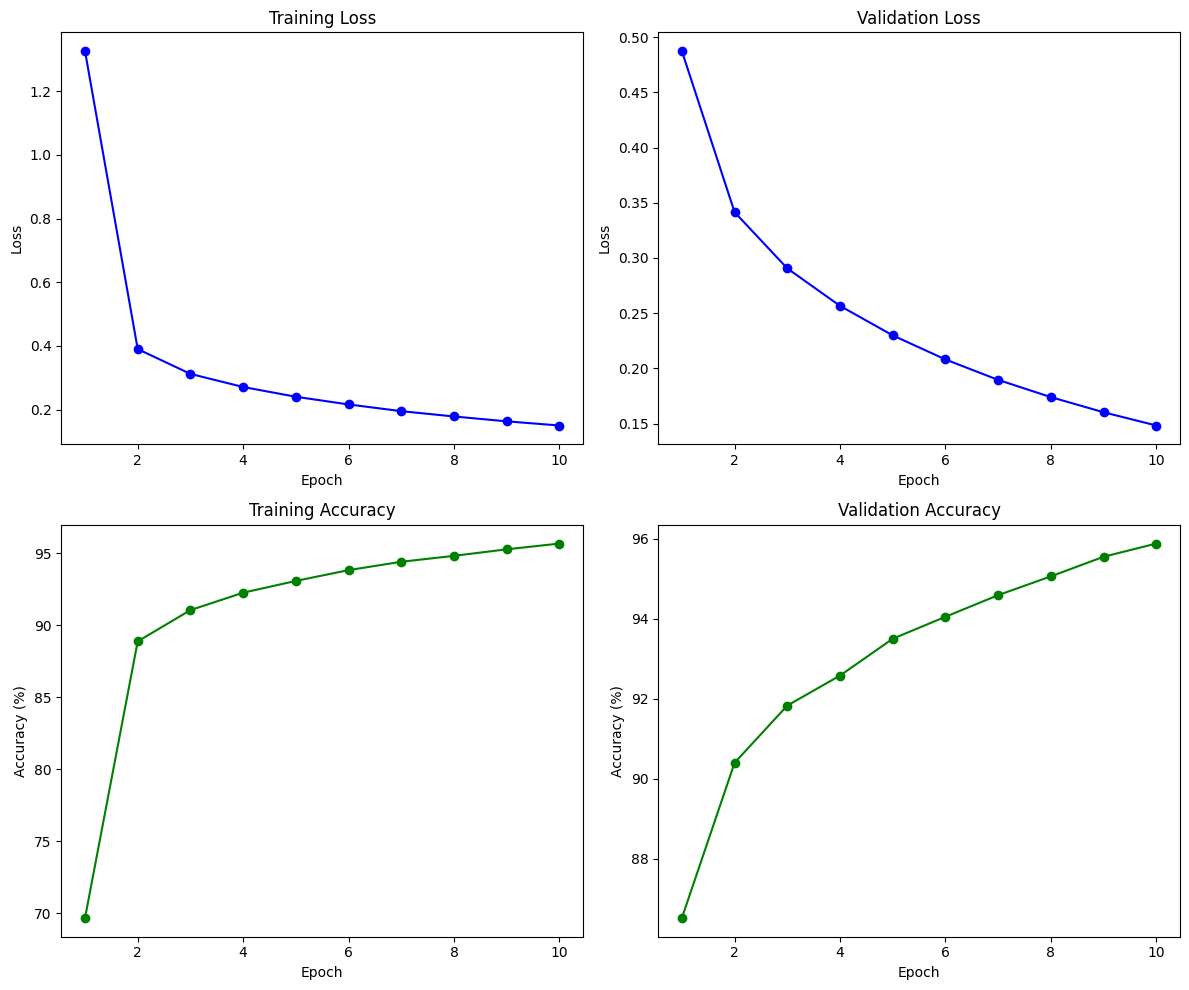

In [16]:
train(model, train_loader, val_loader, loss_fn, optimizer, 10)

*Conclusion*
After 10 epochs:
 - Training Accuracy = 95.66%
 - Validation Accuracy = 95.88%


### **Step 7: Testing the model**

In [ ]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  # Storing all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Reshaping inputs
          inputs = inputs.view(inputs.size(0), -1)  # Automatically handle batch size
          outputs = model(inputs)

          # Get predicted labels
          _, predicted = torch.max(outputs, dim=1)

          # Update metrics
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store predictions and true labels
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate overall accuracy
  test_accuracy = 100 * correct / total
  print(f"Test Accuracy: {test_accuracy:.2f}%")


  cm = confusion_matrix(all_labels, all_preds)

  # Plotting the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  ################################

  # Visualize multiple sample predictions
  sample_indices = [0,1,2,3,4,5]

  num_samples = len(sample_indices)
  plt.figure(figsize=(12, 3 * num_samples))

  for i, index in enumerate(sample_indices):
      sample_image = X_test[index]
      true_label = y_test[index]

      # Prepare the sample for the model
      sample_image = torch.tensor(sample_image).float().view(1, -1)

      with torch.no_grad():
          output = model(sample_image)
          _, predicted_label = torch.max(output, 1)

      # Plot the image
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(sample_image.reshape(28, 28), cmap='gray')
      plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

Test Accuracy: 95.57%


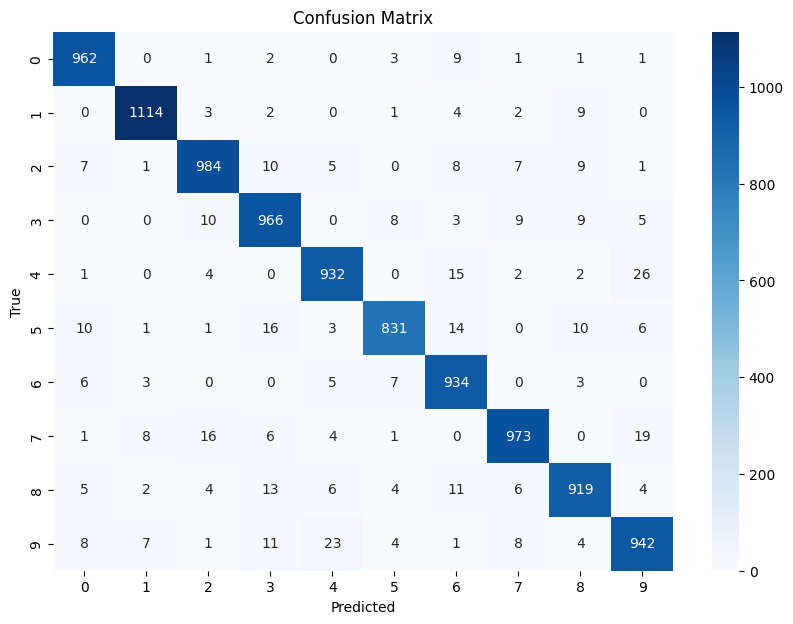

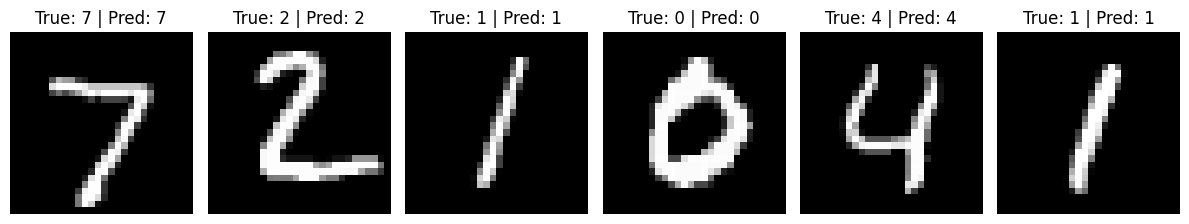

In [30]:
test(model, test_loader)

### **Summary:**

 - Training Accuracy = 95.66%
 - Validation Accuracy = 95.88%
 - Test Accuracy = 95.57%

# **Analysis**

# Change Learning Rate [0.1, 0.05, 0.01, 0.001, 0.0001]
* Batch size = 32
* Neurons number: 128 then 64

At learning rate = 0.1

Epoch [1/10]
Training Loss: 0.4155, Accuracy: 87.43%
Validation Loss: 0.1836, Accuracy: 94.26%
Epoch [2/10]
Training Loss: 0.1390, Accuracy: 95.80%
Validation Loss: 0.1098, Accuracy: 96.65%
Epoch [3/10]
Training Loss: 0.0931, Accuracy: 97.17%
Validation Loss: 0.0775, Accuracy: 97.85%
Epoch [4/10]
Training Loss: 0.0710, Accuracy: 97.79%
Validation Loss: 0.0575, Accuracy: 98.37%
Epoch [5/10]
Training Loss: 0.0554, Accuracy: 98.31%
Validation Loss: 0.0442, Accuracy: 98.86%
Epoch [6/10]
Training Loss: 0.0457, Accuracy: 98.57%
Validation Loss: 0.0363, Accuracy: 99.07%
Epoch [7/10]
Training Loss: 0.0376, Accuracy: 98.80%
Validation Loss: 0.0286, Accuracy: 99.25%
Epoch [8/10]
Training Loss: 0.0310, Accuracy: 99.02%
Validation Loss: 0.0257, Accuracy: 99.21%
Epoch [9/10]
Training Loss: 0.0244, Accuracy: 99.24%
Validation Loss: 0.0195, Accuracy: 99.50%
Epoch [10/10]
Training Loss: 0.0209, Accuracy: 99.34%
Validation Loss: 0.0151, Accuracy: 99.54%


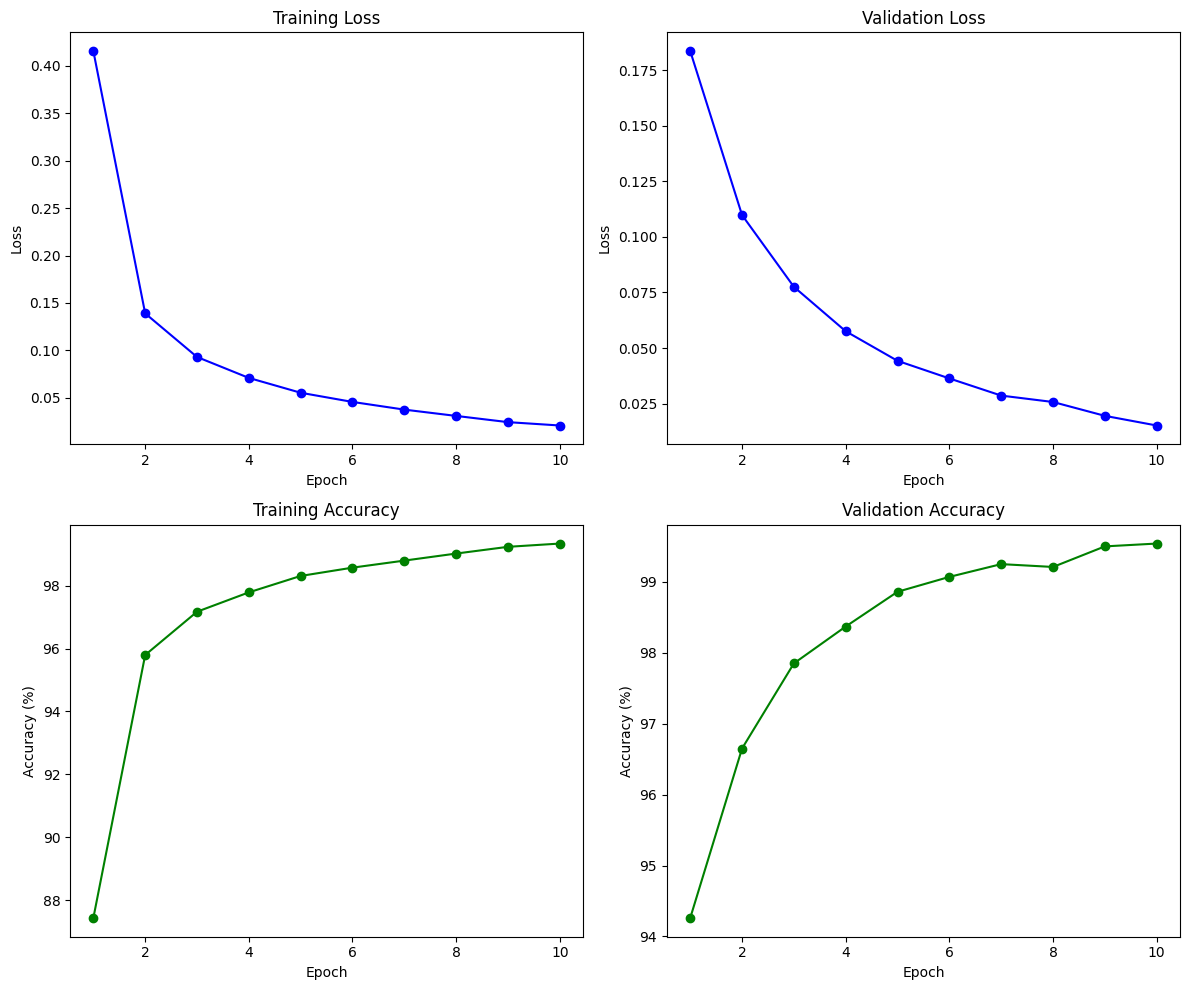

In [15]:
model_1 = FeedforwardNN()
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.1)

train(model_1, train_loader, val_loader, loss_fn_1, optimizer_1, 10)

Test Accuracy: 97.77%


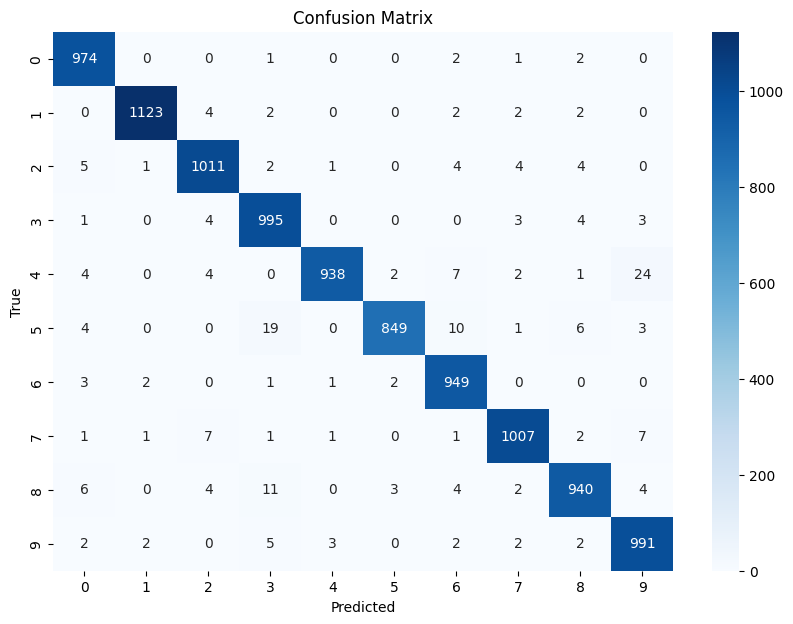

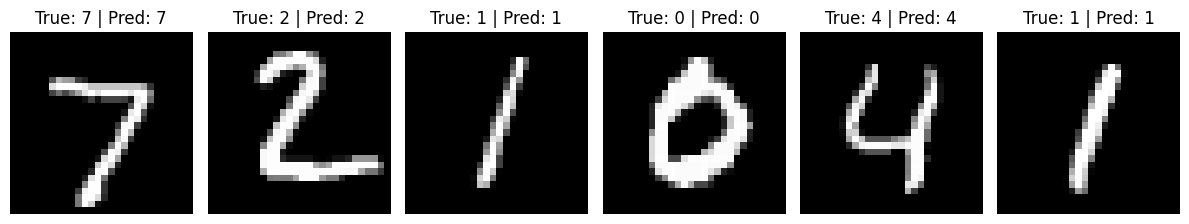

In [16]:
test(model_1, test_loader)

At learning rate = 0.05

Epoch [1/10]
Training Loss: 0.5649, Accuracy: 83.99%
Validation Loss: 0.2609, Accuracy: 92.34%
Epoch [2/10]
Training Loss: 0.2010, Accuracy: 94.02%
Validation Loss: 0.1646, Accuracy: 95.17%
Epoch [3/10]
Training Loss: 0.1348, Accuracy: 96.07%
Validation Loss: 0.1212, Accuracy: 96.46%
Epoch [4/10]
Training Loss: 0.1013, Accuracy: 97.00%
Validation Loss: 0.0935, Accuracy: 97.23%
Epoch [5/10]
Training Loss: 0.0817, Accuracy: 97.55%
Validation Loss: 0.0746, Accuracy: 97.83%
Epoch [6/10]
Training Loss: 0.0675, Accuracy: 97.96%
Validation Loss: 0.0612, Accuracy: 98.31%
Epoch [7/10]
Training Loss: 0.0570, Accuracy: 98.27%
Validation Loss: 0.0507, Accuracy: 98.69%
Epoch [8/10]
Training Loss: 0.0485, Accuracy: 98.50%
Validation Loss: 0.0429, Accuracy: 98.85%
Epoch [9/10]
Training Loss: 0.0408, Accuracy: 98.78%
Validation Loss: 0.0365, Accuracy: 99.03%
Epoch [10/10]
Training Loss: 0.0353, Accuracy: 98.93%
Validation Loss: 0.0306, Accuracy: 99.24%


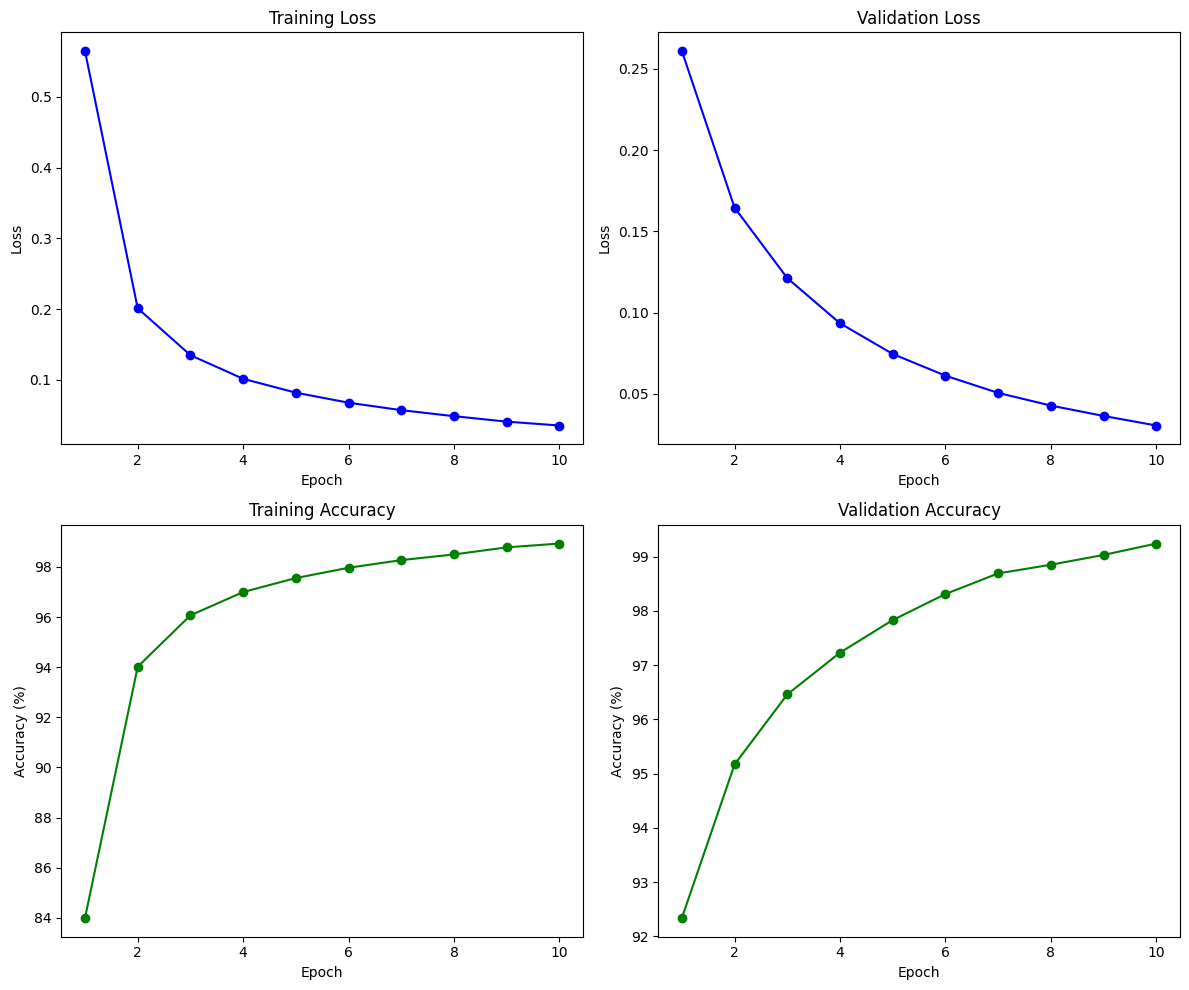

In [17]:
model_2 = FeedforwardNN()
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.05)

train(model_2, train_loader, val_loader, loss_fn_2, optimizer_2, 10)

Test Accuracy: 97.71%


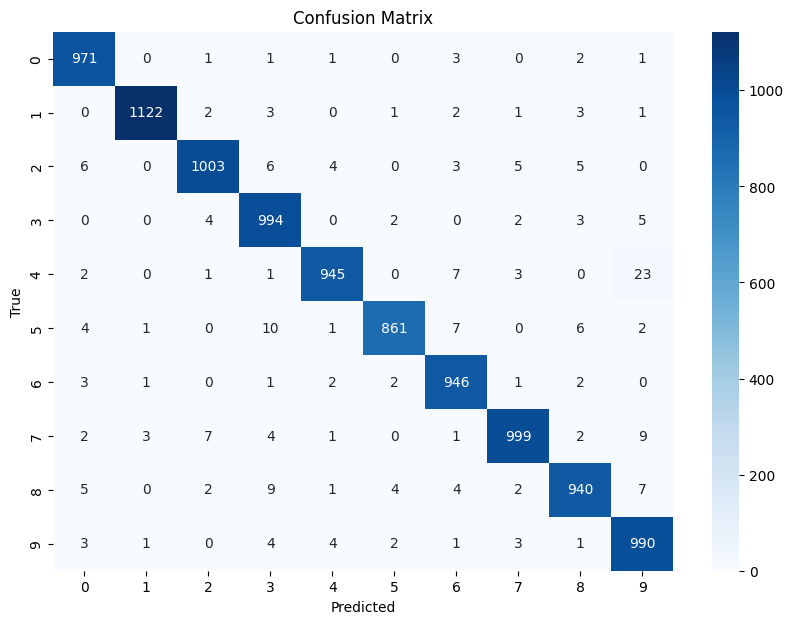

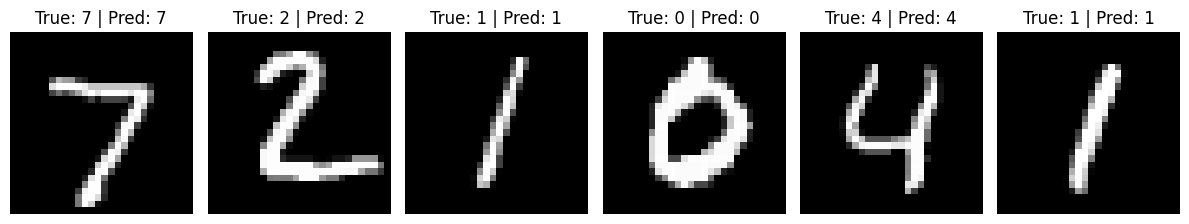

In [18]:
test(model_2, test_loader)

At learning rate = 0.01

Epoch [1/10]
Training Loss: 1.3228, Accuracy: 63.24%
Validation Loss: 0.4777, Accuracy: 86.77%
Epoch [2/10]
Training Loss: 0.3855, Accuracy: 89.09%
Validation Loss: 0.3394, Accuracy: 90.46%
Epoch [3/10]
Training Loss: 0.3118, Accuracy: 91.00%
Validation Loss: 0.2901, Accuracy: 91.84%
Epoch [4/10]
Training Loss: 0.2713, Accuracy: 92.11%
Validation Loss: 0.2570, Accuracy: 92.72%
Epoch [5/10]
Training Loss: 0.2413, Accuracy: 93.08%
Validation Loss: 0.2309, Accuracy: 93.43%
Epoch [6/10]
Training Loss: 0.2165, Accuracy: 93.82%
Validation Loss: 0.2093, Accuracy: 94.04%
Epoch [7/10]
Training Loss: 0.1959, Accuracy: 94.31%
Validation Loss: 0.1906, Accuracy: 94.62%
Epoch [8/10]
Training Loss: 0.1781, Accuracy: 94.84%
Validation Loss: 0.1747, Accuracy: 95.00%
Epoch [9/10]
Training Loss: 0.1625, Accuracy: 95.26%
Validation Loss: 0.1608, Accuracy: 95.27%
Epoch [10/10]
Training Loss: 0.1493, Accuracy: 95.69%
Validation Loss: 0.1488, Accuracy: 95.69%


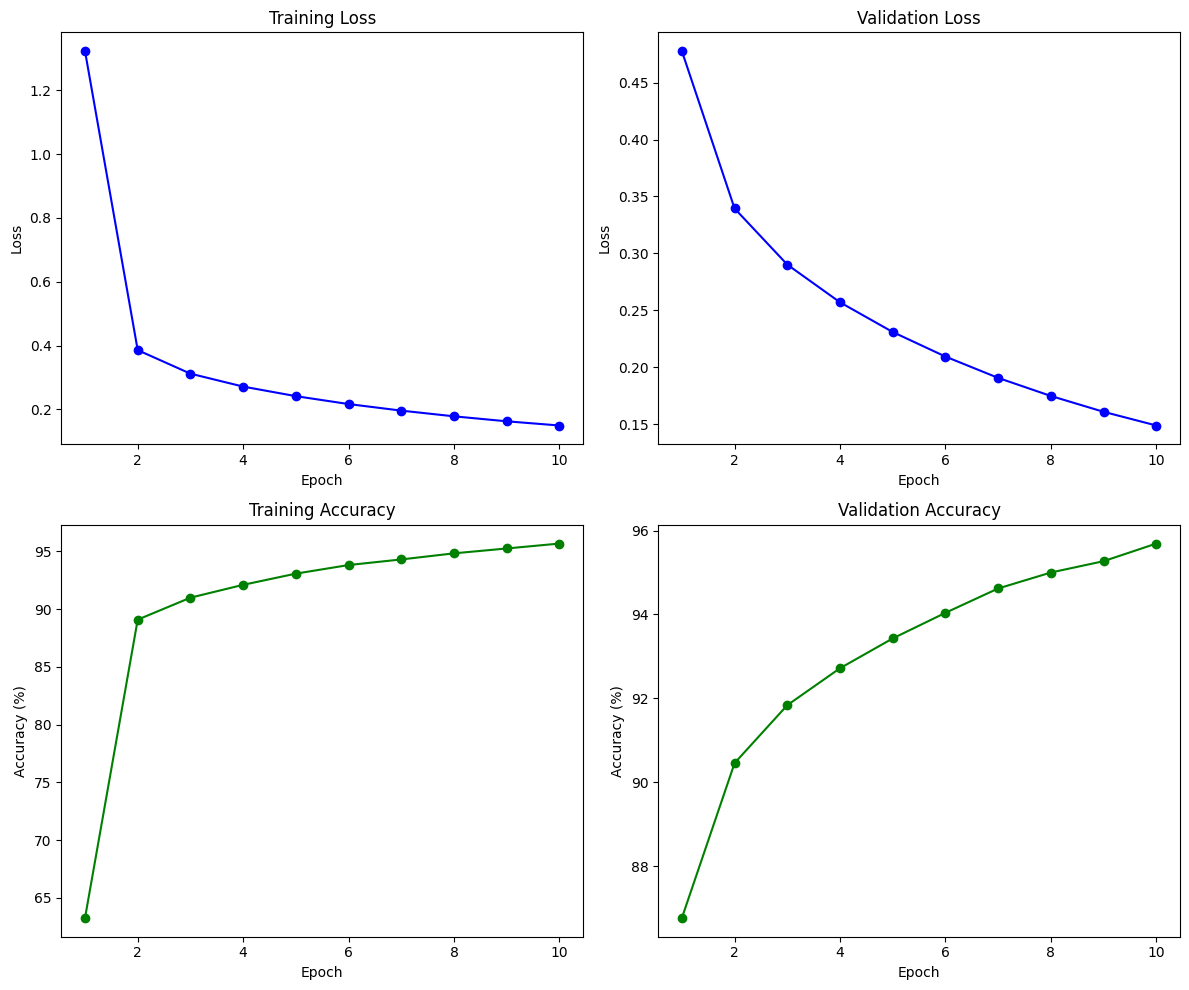

In [19]:
model_3 = FeedforwardNN()
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.01)

train(model_3, train_loader, val_loader, loss_fn_3, optimizer_3, 10)

Test Accuracy: 95.51%


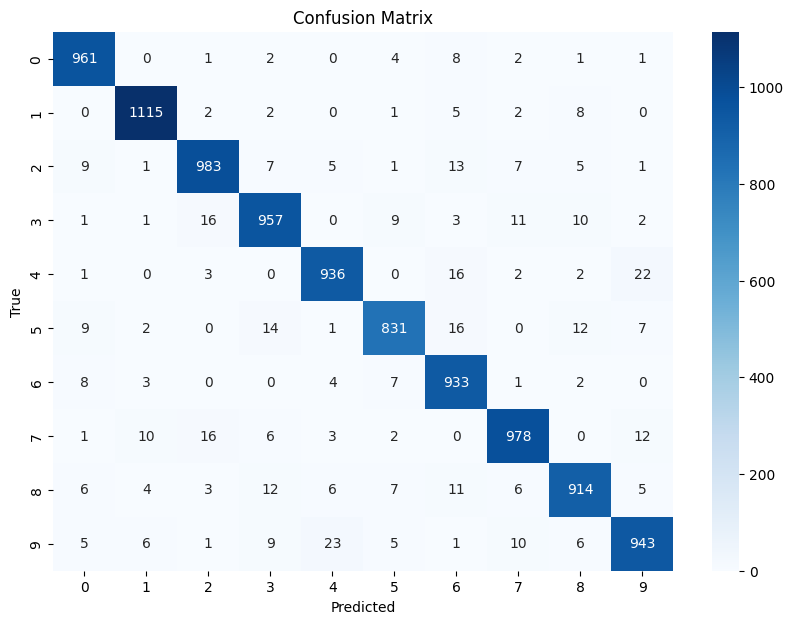

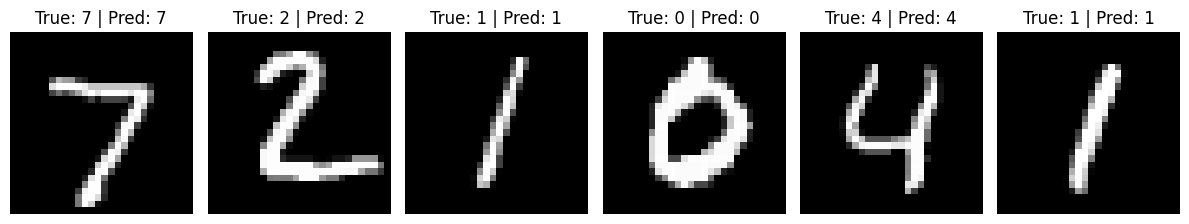

In [20]:
test(model_3, test_loader)

At learning rate = 0.001

Epoch [1/10]
Training Loss: 2.2783, Accuracy: 14.74%
Validation Loss: 2.2441, Accuracy: 34.49%
Epoch [2/10]
Training Loss: 2.1841, Accuracy: 44.59%
Validation Loss: 2.0970, Accuracy: 44.71%
Epoch [3/10]
Training Loss: 1.9518, Accuracy: 47.34%
Validation Loss: 1.7655, Accuracy: 55.07%
Epoch [4/10]
Training Loss: 1.5325, Accuracy: 65.78%
Validation Loss: 1.2905, Accuracy: 74.53%
Epoch [5/10]
Training Loss: 1.0759, Accuracy: 77.56%
Validation Loss: 0.9060, Accuracy: 80.35%
Epoch [6/10]
Training Loss: 0.7871, Accuracy: 81.29%
Validation Loss: 0.7016, Accuracy: 82.79%
Epoch [7/10]
Training Loss: 0.6361, Accuracy: 83.57%
Validation Loss: 0.5916, Accuracy: 84.39%
Epoch [8/10]
Training Loss: 0.5510, Accuracy: 85.18%
Validation Loss: 0.5259, Accuracy: 85.71%
Epoch [9/10]
Training Loss: 0.4982, Accuracy: 86.32%
Validation Loss: 0.4826, Accuracy: 86.74%
Epoch [10/10]
Training Loss: 0.4620, Accuracy: 87.21%
Validation Loss: 0.4520, Accuracy: 87.46%


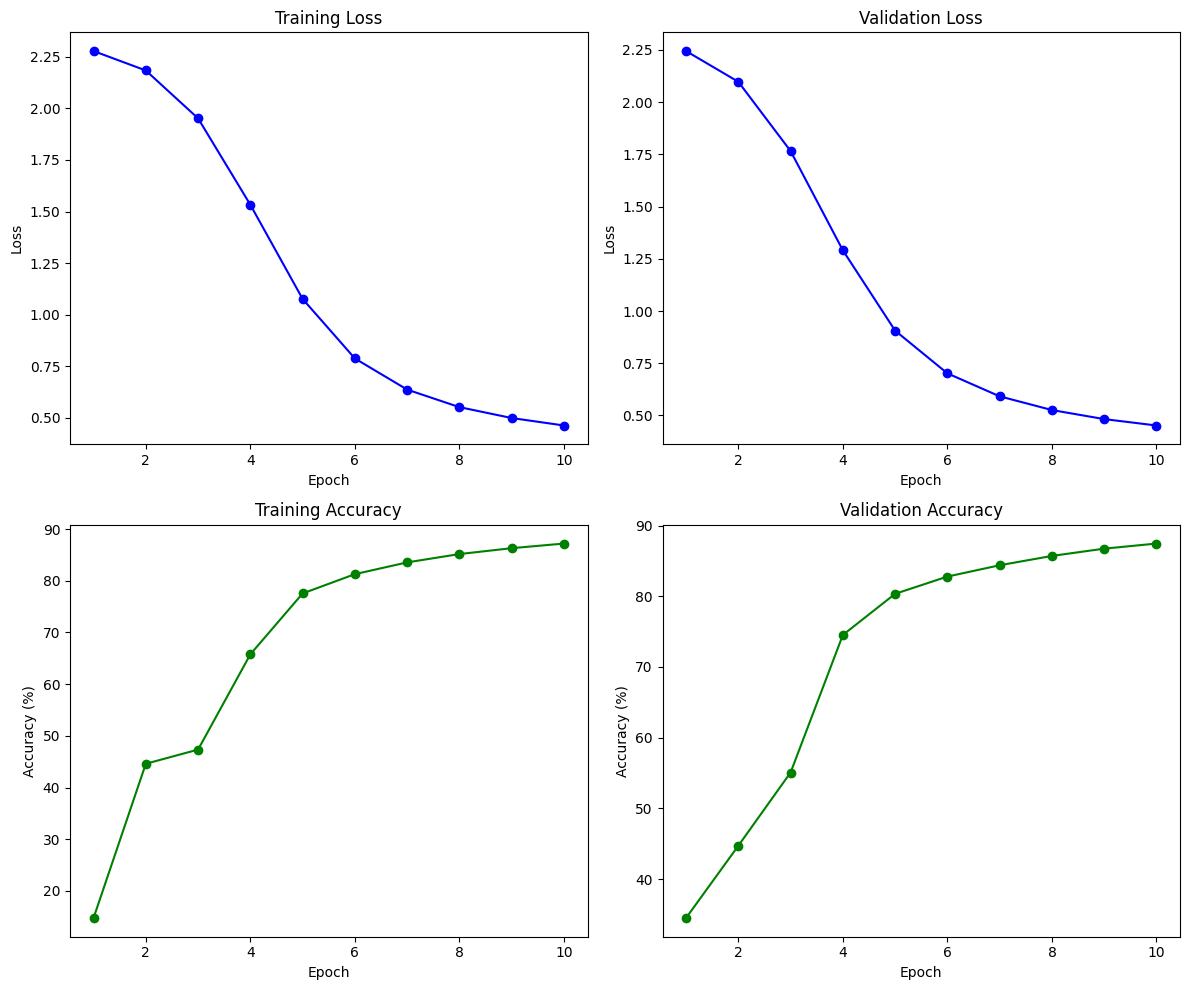

In [21]:
model_4 = FeedforwardNN()
loss_fn_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.001)

train(model_4, train_loader, val_loader, loss_fn_4, optimizer_4, 10)


Test Accuracy: 87.81%


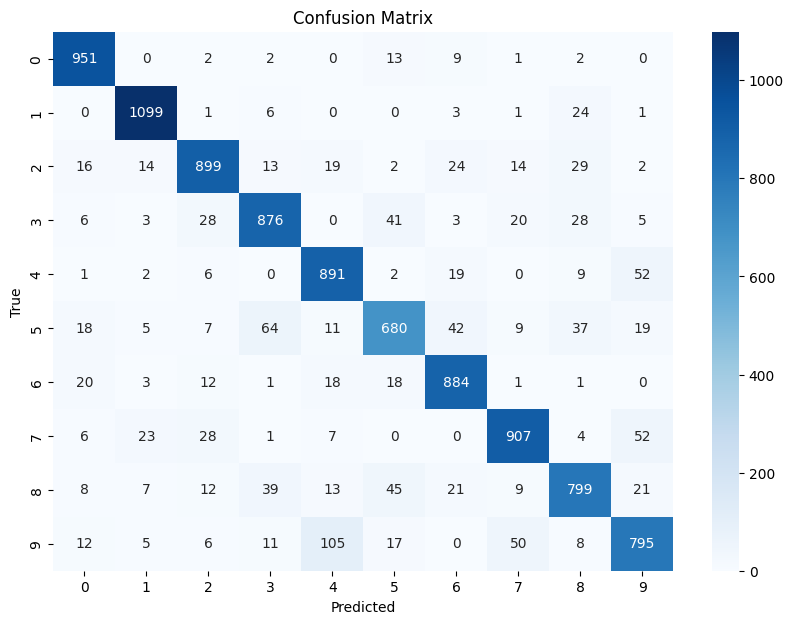

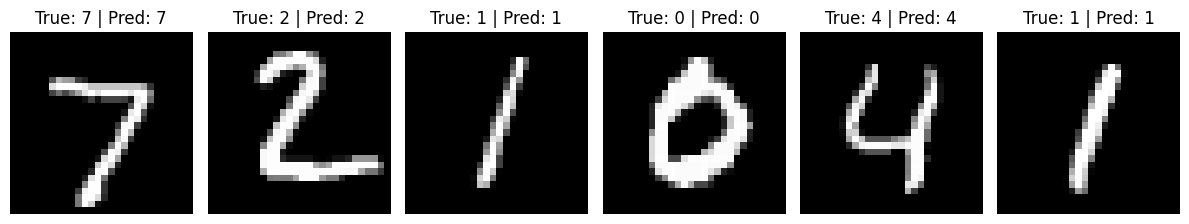

In [22]:
test(model_4, test_loader)

At learning rate = 0.0001

Epoch [1/10]
Training Loss: 1.3633, Accuracy: 65.23%
Validation Loss: 0.5109, Accuracy: 85.57%
Epoch [2/10]
Training Loss: 0.3993, Accuracy: 88.74%
Validation Loss: 0.3459, Accuracy: 90.29%
Epoch [3/10]
Training Loss: 0.3151, Accuracy: 90.95%
Validation Loss: 0.2940, Accuracy: 91.66%
Epoch [4/10]
Training Loss: 0.2743, Accuracy: 92.13%
Validation Loss: 0.2596, Accuracy: 92.55%
Epoch [5/10]
Training Loss: 0.2432, Accuracy: 93.04%
Validation Loss: 0.2318, Accuracy: 93.33%
Epoch [6/10]
Training Loss: 0.2166, Accuracy: 93.77%
Validation Loss: 0.2080, Accuracy: 94.07%
Epoch [7/10]
Training Loss: 0.1947, Accuracy: 94.45%
Validation Loss: 0.1880, Accuracy: 94.69%
Epoch [8/10]
Training Loss: 0.1758, Accuracy: 94.95%
Validation Loss: 0.1715, Accuracy: 95.08%
Epoch [9/10]
Training Loss: 0.1604, Accuracy: 95.36%
Validation Loss: 0.1574, Accuracy: 95.52%
Epoch [10/10]
Training Loss: 0.1467, Accuracy: 95.73%
Validation Loss: 0.1456, Accuracy: 95.87%


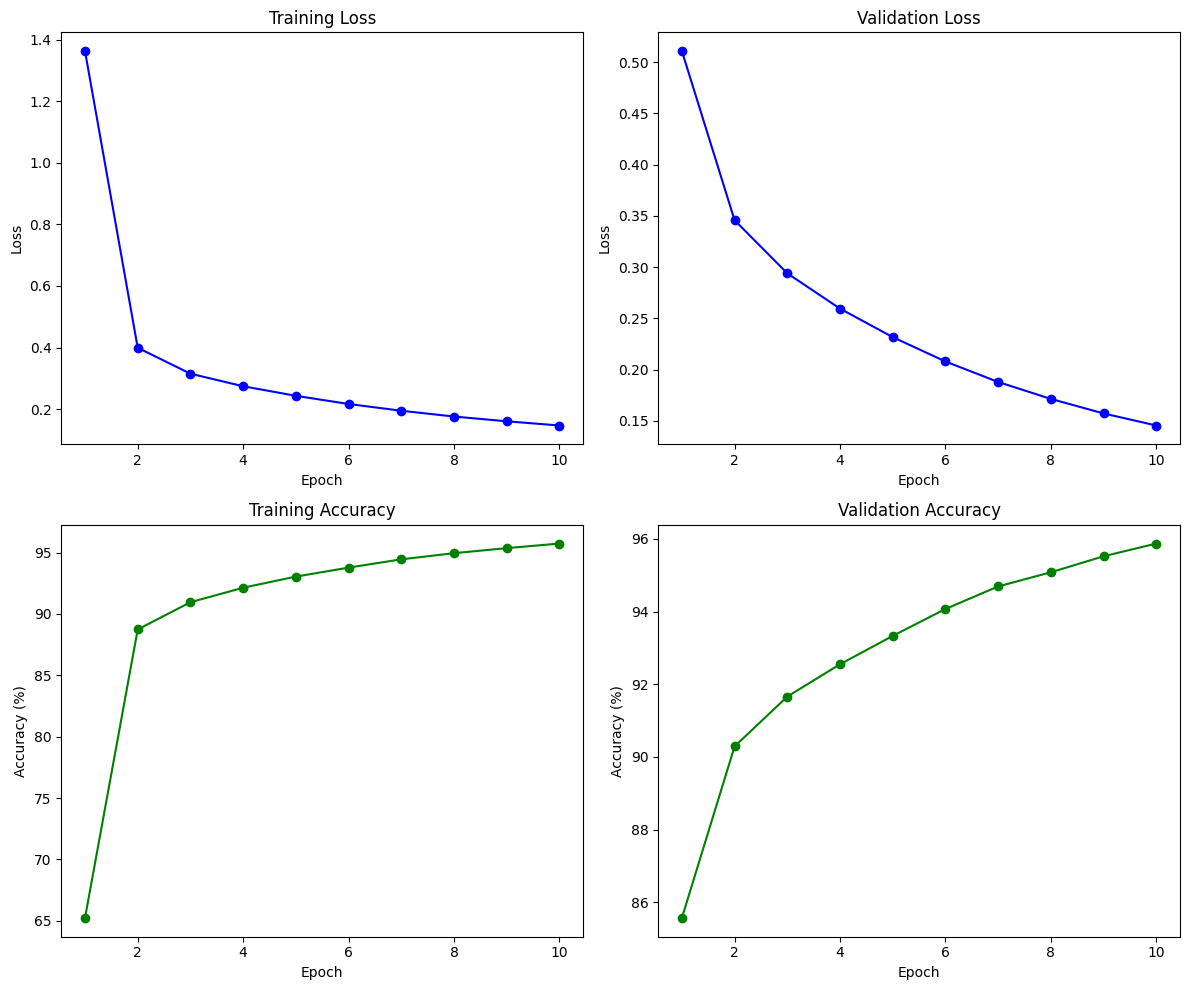

In [23]:
model_5 = FeedforwardNN()
loss_fn_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(model_5.parameters(), lr=0.01)

train(model_5, train_loader, val_loader, loss_fn_5, optimizer_5, 10)

Test Accuracy: 95.67%


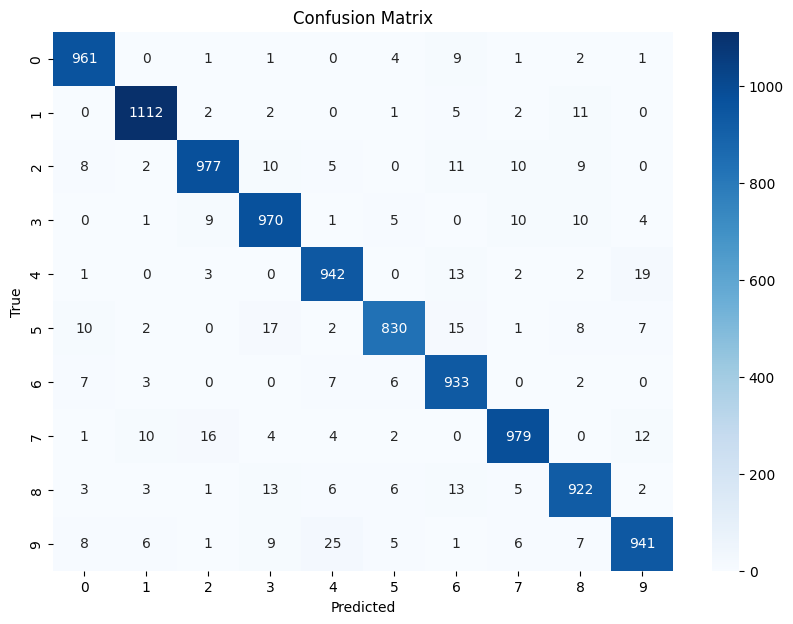

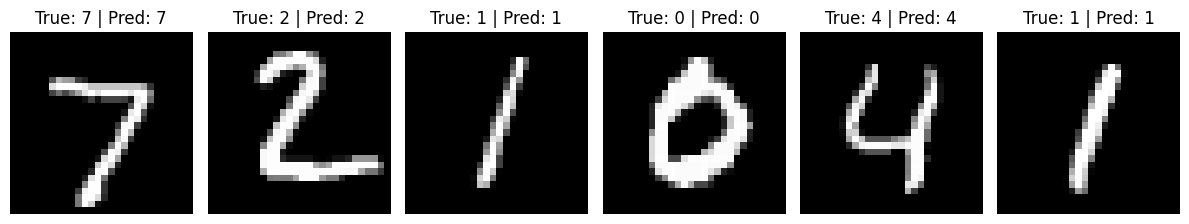

In [24]:
test(model_5, test_loader)

* At learning rate = **0.1** --- Accuracy = **97.77%**
* At learning rate = **0.05** --- Accuracy = **97.71%**
* At learning rate = **0.01** --- Accuracy = **95.51%**
* At learning rate = **0.001** --- Accuracy = **87.81%**
* At learning rate = **0.0001** --- Accuracy = **95.67%**

Then we choose leaning rate = **0.1** which is model_1 as it gives the highest accuracy

# Change Batch size [32, 64, 128, 256, 512]
* Learning rate = 0.1
* Neurons number: 128 then 64

At batch size = 32

Epoch [1/10]
Training Loss: 0.4063, Accuracy: 88.04%
Validation Loss: 0.1876, Accuracy: 94.48%
Epoch [2/10]
Training Loss: 0.1401, Accuracy: 95.82%
Validation Loss: 0.1134, Accuracy: 96.42%
Epoch [3/10]
Training Loss: 0.0960, Accuracy: 97.05%
Validation Loss: 0.0820, Accuracy: 97.45%
Epoch [4/10]
Training Loss: 0.0732, Accuracy: 97.76%
Validation Loss: 0.0607, Accuracy: 98.08%
Epoch [5/10]
Training Loss: 0.0606, Accuracy: 98.07%
Validation Loss: 0.0465, Accuracy: 98.50%
Epoch [6/10]
Training Loss: 0.0478, Accuracy: 98.49%
Validation Loss: 0.0346, Accuracy: 99.04%
Epoch [7/10]
Training Loss: 0.0399, Accuracy: 98.75%
Validation Loss: 0.0277, Accuracy: 99.31%
Epoch [8/10]
Training Loss: 0.0320, Accuracy: 98.96%
Validation Loss: 0.0263, Accuracy: 99.19%
Epoch [9/10]
Training Loss: 0.0277, Accuracy: 99.08%
Validation Loss: 0.0201, Accuracy: 99.46%
Epoch [10/10]
Training Loss: 0.0214, Accuracy: 99.31%
Validation Loss: 0.0177, Accuracy: 99.49%


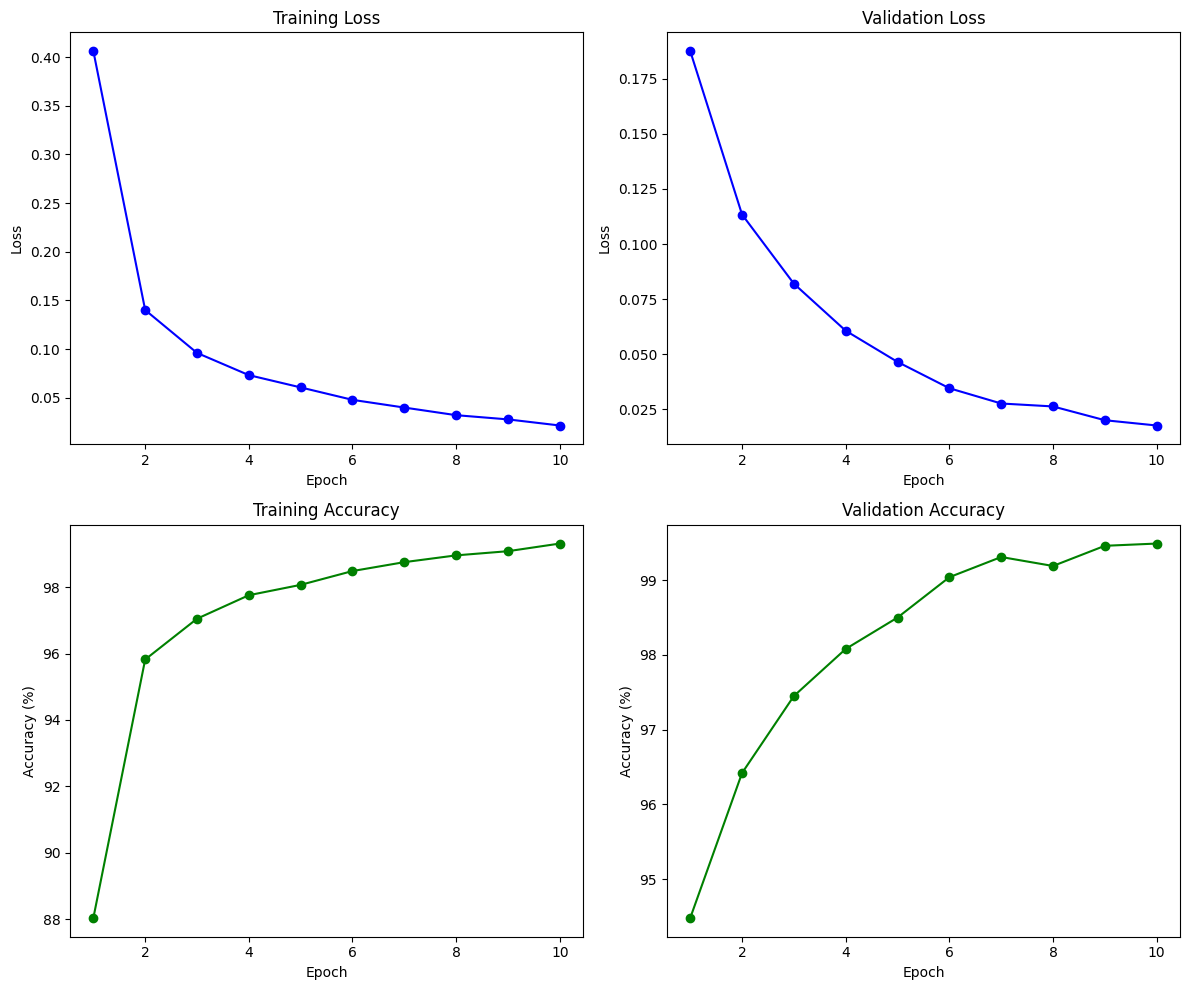

In [25]:
batch_size = 32

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_6 = FeedforwardNN()
loss_fn_6 = nn.CrossEntropyLoss()
optimizer_6 = optim.SGD(model_6.parameters(), lr=0.1)

train(model_6, train_loader, val_loader, loss_fn_6, optimizer_6, 10)

Test Accuracy: 97.56%


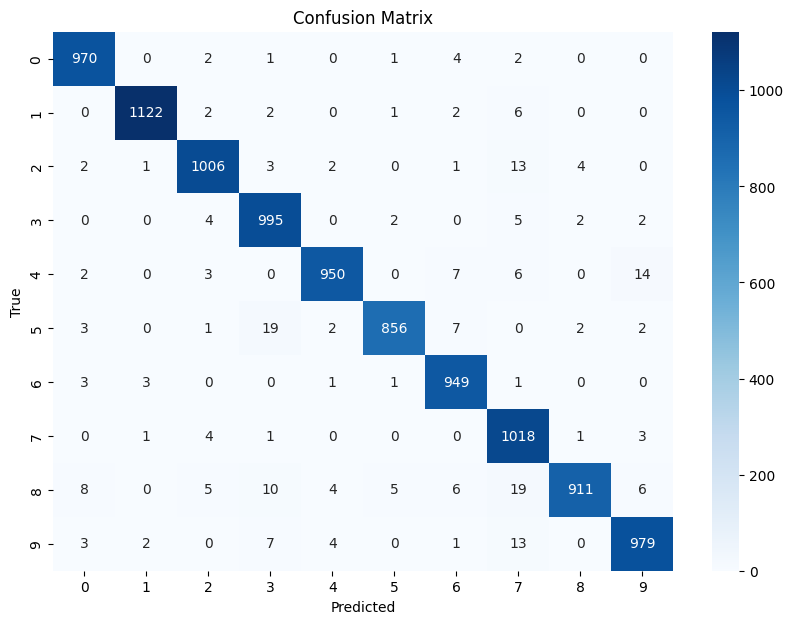

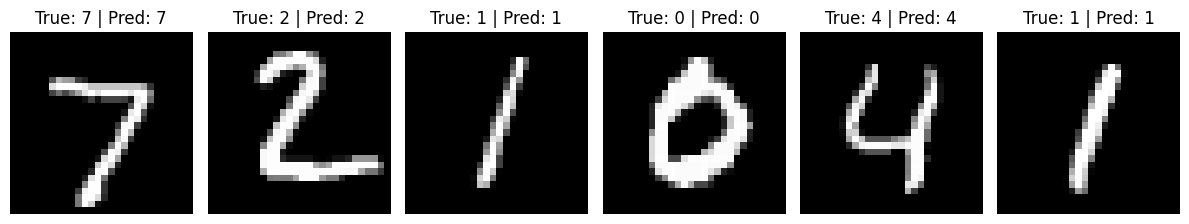

In [26]:
test(model_6, test_loader)

At batch size = 64

Epoch [1/10]
Training Loss: 0.5441, Accuracy: 84.84%
Validation Loss: 0.2530, Accuracy: 92.74%
Epoch [2/10]
Training Loss: 0.1969, Accuracy: 94.25%
Validation Loss: 0.1635, Accuracy: 94.98%
Epoch [3/10]
Training Loss: 0.1347, Accuracy: 96.07%
Validation Loss: 0.1198, Accuracy: 96.38%
Epoch [4/10]
Training Loss: 0.1045, Accuracy: 96.83%
Validation Loss: 0.0930, Accuracy: 97.15%
Epoch [5/10]
Training Loss: 0.0824, Accuracy: 97.51%
Validation Loss: 0.0749, Accuracy: 97.74%
Epoch [6/10]
Training Loss: 0.0688, Accuracy: 97.90%
Validation Loss: 0.0608, Accuracy: 98.23%
Epoch [7/10]
Training Loss: 0.0561, Accuracy: 98.34%
Validation Loss: 0.0490, Accuracy: 98.69%
Epoch [8/10]
Training Loss: 0.0484, Accuracy: 98.51%
Validation Loss: 0.0423, Accuracy: 98.84%
Epoch [9/10]
Training Loss: 0.0414, Accuracy: 98.73%
Validation Loss: 0.0344, Accuracy: 99.16%
Epoch [10/10]
Training Loss: 0.0345, Accuracy: 98.97%
Validation Loss: 0.0287, Accuracy: 99.28%


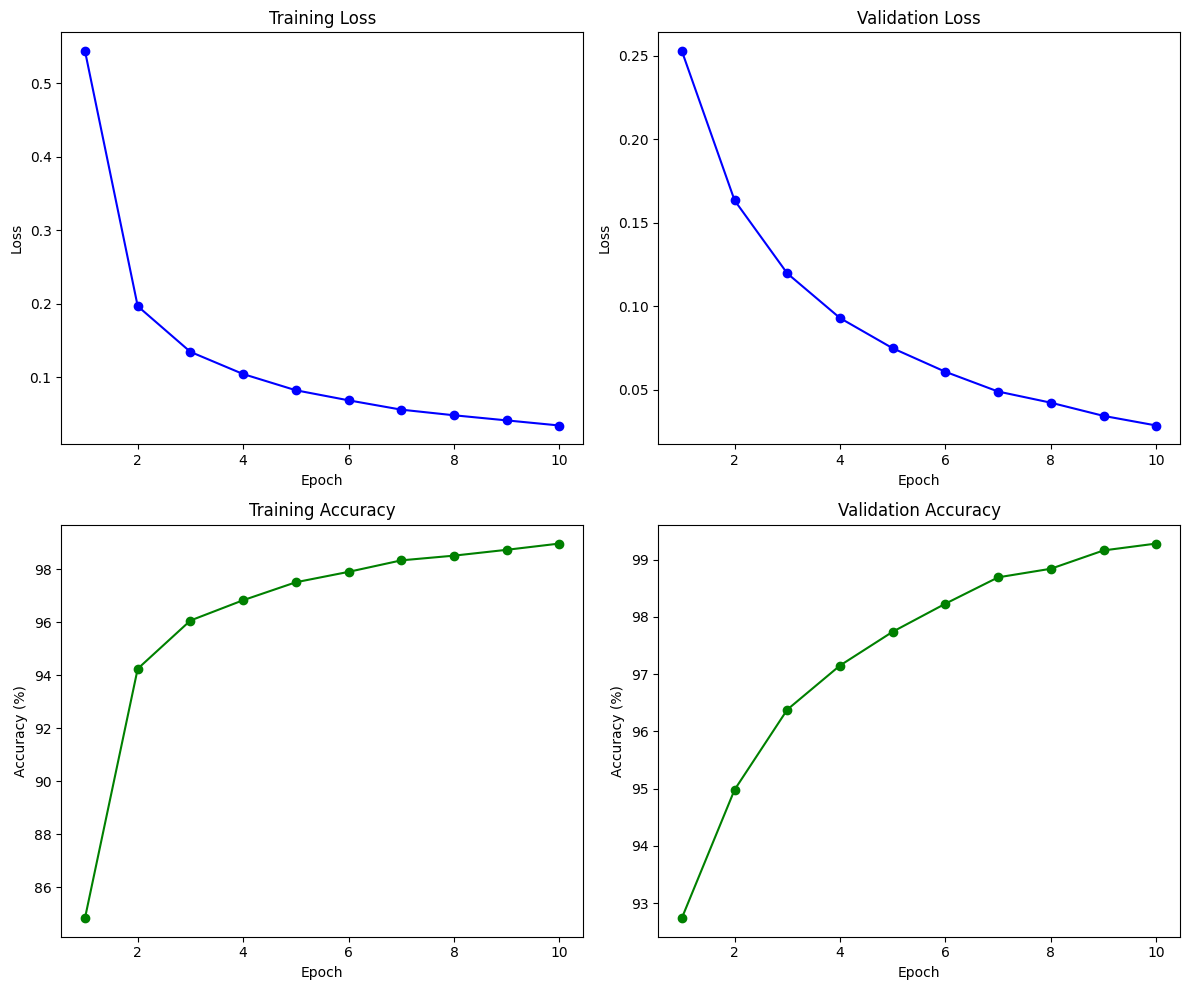

In [27]:
batch_size = 64

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_7 = FeedforwardNN()
loss_fn_7 = nn.CrossEntropyLoss()
optimizer_7 = optim.SGD(model_7.parameters(), lr=0.1)

train(model_7, train_loader, val_loader, loss_fn_7, optimizer_7, 10)

Test Accuracy: 97.87%


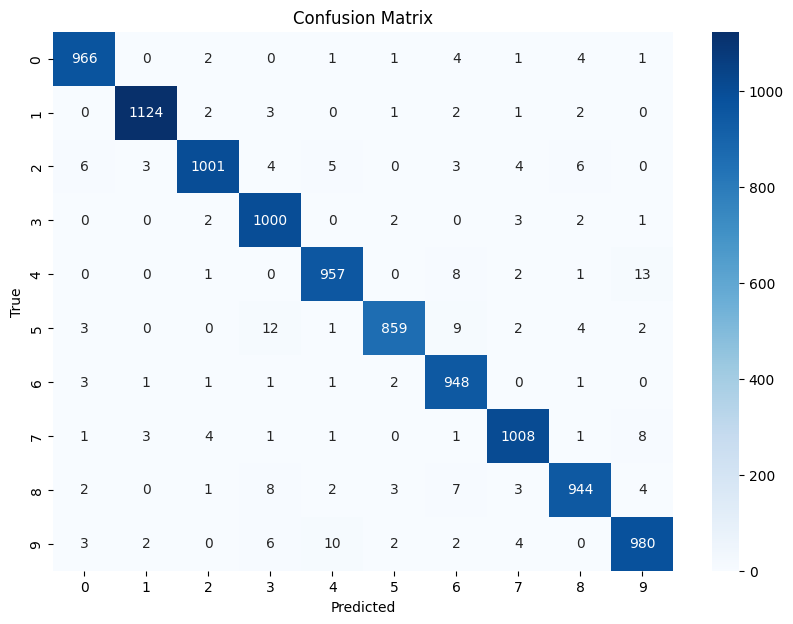

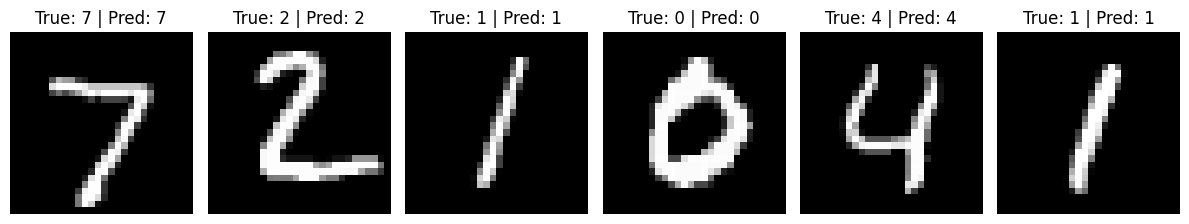

In [28]:
test(model_7, test_loader)

At batch size = 128

Epoch [1/10]
Training Loss: 0.7892, Accuracy: 77.90%
Validation Loss: 0.3426, Accuracy: 90.05%
Epoch [2/10]
Training Loss: 0.2855, Accuracy: 91.65%
Validation Loss: 0.2387, Accuracy: 92.99%
Epoch [3/10]
Training Loss: 0.2071, Accuracy: 93.93%
Validation Loss: 0.1817, Accuracy: 94.56%
Epoch [4/10]
Training Loss: 0.1619, Accuracy: 95.24%
Validation Loss: 0.1472, Accuracy: 95.60%
Epoch [5/10]
Training Loss: 0.1316, Accuracy: 96.17%
Validation Loss: 0.1227, Accuracy: 96.30%
Epoch [6/10]
Training Loss: 0.1101, Accuracy: 96.82%
Validation Loss: 0.1036, Accuracy: 96.99%
Epoch [7/10]
Training Loss: 0.0944, Accuracy: 97.24%
Validation Loss: 0.0892, Accuracy: 97.36%
Epoch [8/10]
Training Loss: 0.0826, Accuracy: 97.57%
Validation Loss: 0.0776, Accuracy: 97.71%
Epoch [9/10]
Training Loss: 0.0729, Accuracy: 97.80%
Validation Loss: 0.0679, Accuracy: 98.13%
Epoch [10/10]
Training Loss: 0.0656, Accuracy: 98.09%
Validation Loss: 0.0609, Accuracy: 98.23%


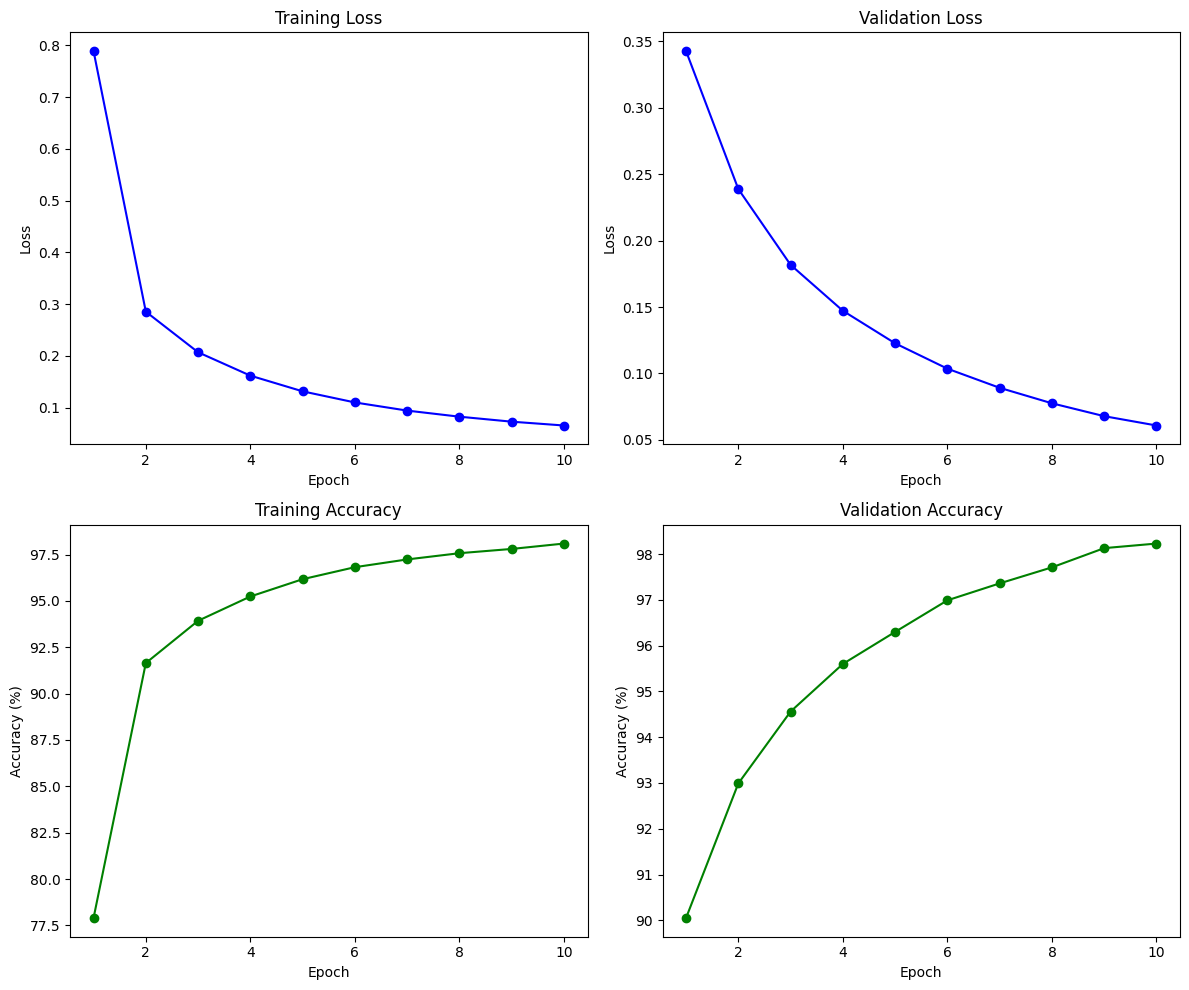

In [29]:
batch_size = 128

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_8 = FeedforwardNN()
loss_fn_8 = nn.CrossEntropyLoss()
optimizer_8 = optim.SGD(model_8.parameters(), lr=0.1)

train(model_8, train_loader, val_loader, loss_fn_8, optimizer_8, 10)

Test Accuracy: 97.47%


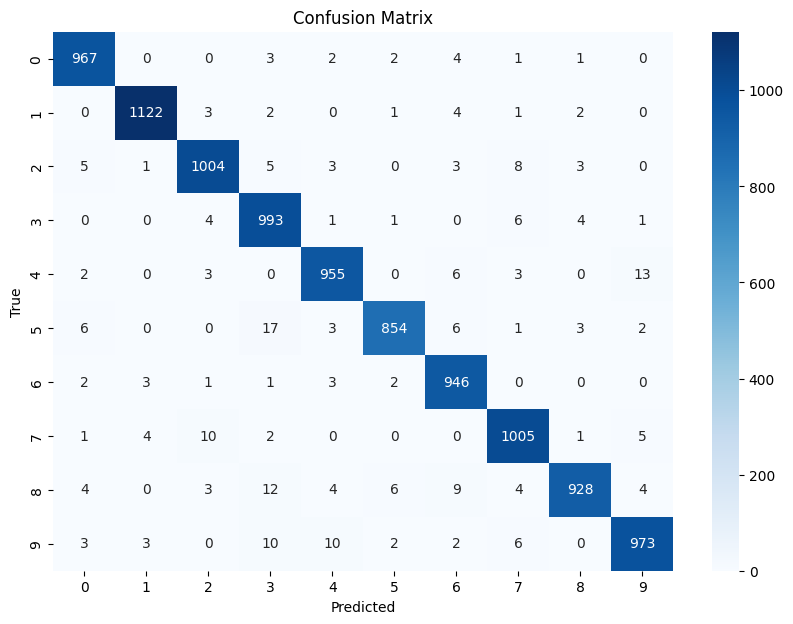

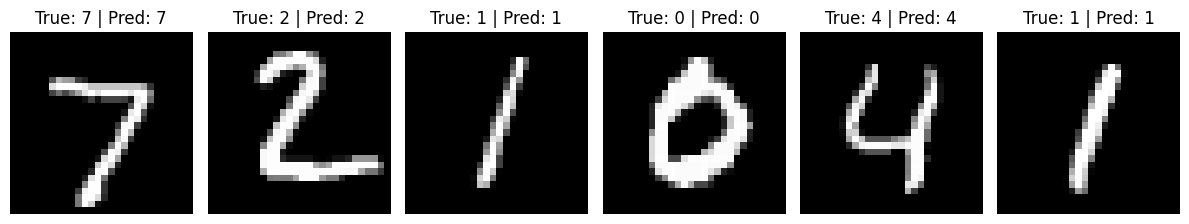

In [30]:
test(model_8, test_loader)

At batch size = 256

Epoch [1/10]
Training Loss: 1.1587, Accuracy: 67.50%
Validation Loss: 0.4378, Accuracy: 87.48%
Epoch [2/10]
Training Loss: 0.3725, Accuracy: 89.24%
Validation Loss: 0.3222, Accuracy: 90.95%
Epoch [3/10]
Training Loss: 0.3003, Accuracy: 91.38%
Validation Loss: 0.2726, Accuracy: 91.97%
Epoch [4/10]
Training Loss: 0.2539, Accuracy: 92.68%
Validation Loss: 0.2331, Accuracy: 93.14%
Epoch [5/10]
Training Loss: 0.2183, Accuracy: 93.80%
Validation Loss: 0.2029, Accuracy: 93.87%
Epoch [6/10]
Training Loss: 0.1899, Accuracy: 94.53%
Validation Loss: 0.1794, Accuracy: 94.59%
Epoch [7/10]
Training Loss: 0.1669, Accuracy: 95.21%
Validation Loss: 0.1598, Accuracy: 95.31%
Epoch [8/10]
Training Loss: 0.1499, Accuracy: 95.68%
Validation Loss: 0.1440, Accuracy: 95.77%
Epoch [9/10]
Training Loss: 0.1360, Accuracy: 96.11%
Validation Loss: 0.1311, Accuracy: 96.10%
Epoch [10/10]
Training Loss: 0.1225, Accuracy: 96.55%
Validation Loss: 0.1199, Accuracy: 96.50%


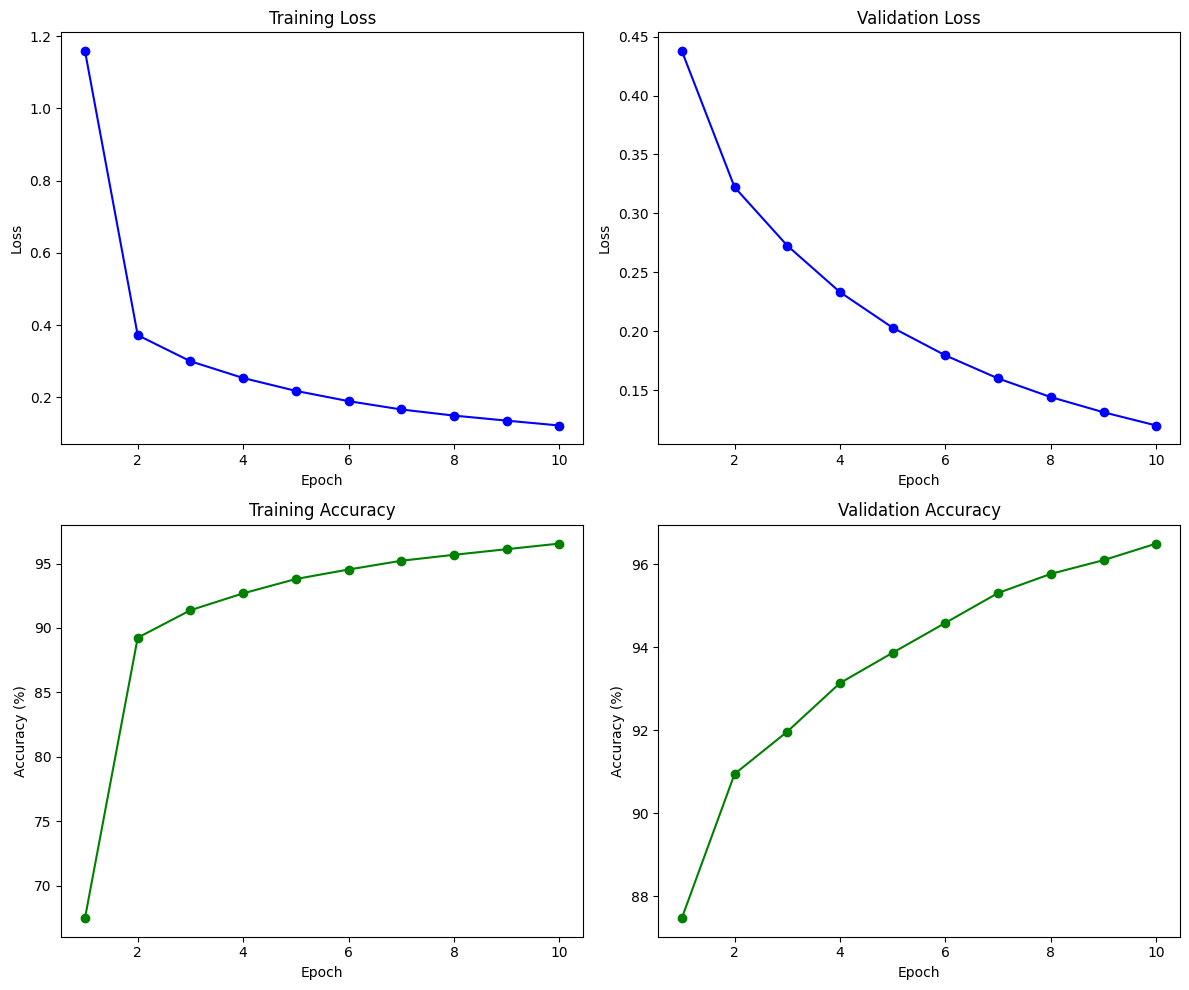

In [31]:
batch_size = 256

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_9 = FeedforwardNN()
loss_fn_9 = nn.CrossEntropyLoss()
optimizer_9 = optim.SGD(model_9.parameters(), lr=0.1)

train(model_9, train_loader, val_loader, loss_fn_9, optimizer_9, 10)

Test Accuracy: 96.40%


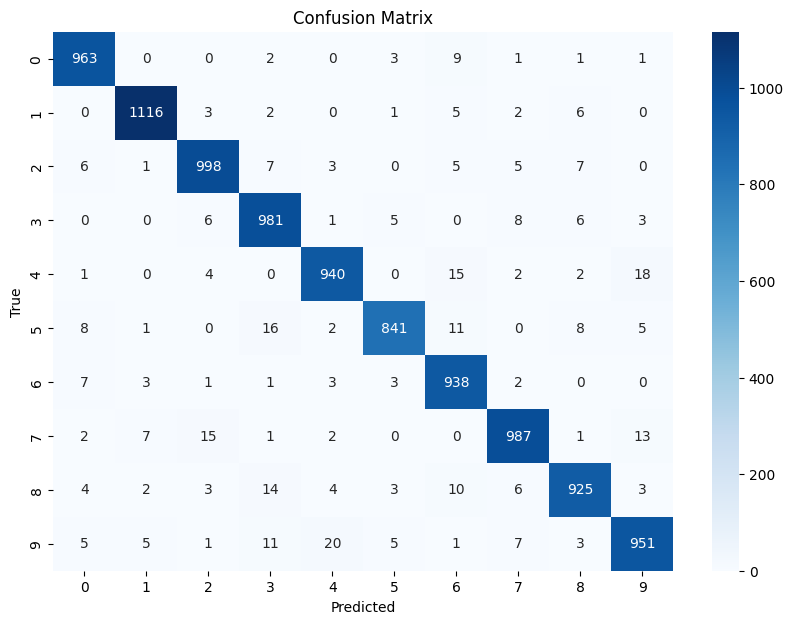

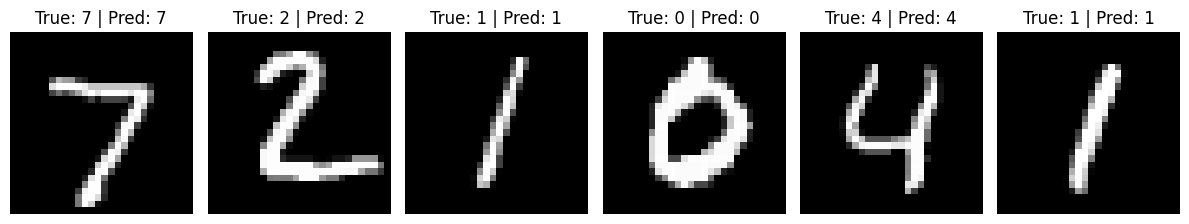

In [32]:
test(model_9, test_loader)

At batch size = 512

Epoch [1/10]
Training Loss: 1.8173, Accuracy: 51.44%
Validation Loss: 0.8217, Accuracy: 78.26%
Epoch [2/10]
Training Loss: 0.5391, Accuracy: 85.21%
Validation Loss: 0.4269, Accuracy: 88.17%
Epoch [3/10]
Training Loss: 0.3874, Accuracy: 88.94%
Validation Loss: 0.3554, Accuracy: 90.16%
Epoch [4/10]
Training Loss: 0.3352, Accuracy: 90.35%
Validation Loss: 0.3173, Accuracy: 91.03%
Epoch [5/10]
Training Loss: 0.3022, Accuracy: 91.23%
Validation Loss: 0.2885, Accuracy: 91.80%
Epoch [6/10]
Training Loss: 0.2767, Accuracy: 91.97%
Validation Loss: 0.2670, Accuracy: 92.33%
Epoch [7/10]
Training Loss: 0.2559, Accuracy: 92.68%
Validation Loss: 0.2477, Accuracy: 93.01%
Epoch [8/10]
Training Loss: 0.2379, Accuracy: 93.23%
Validation Loss: 0.2314, Accuracy: 93.44%
Epoch [9/10]
Training Loss: 0.2224, Accuracy: 93.66%
Validation Loss: 0.2178, Accuracy: 93.86%
Epoch [10/10]
Training Loss: 0.2077, Accuracy: 94.03%
Validation Loss: 0.2046, Accuracy: 94.33%


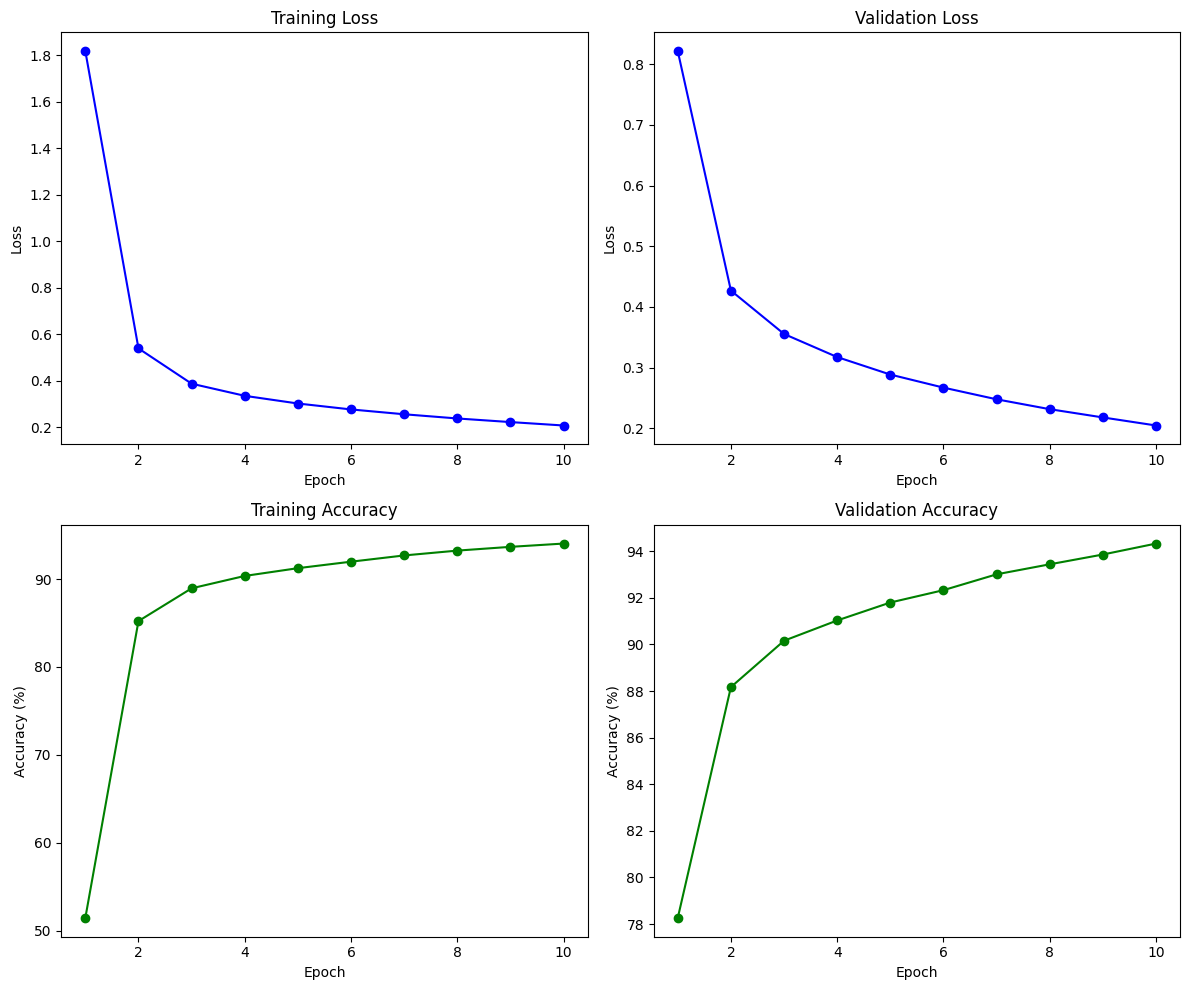

In [33]:
batch_size = 512

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_10 = FeedforwardNN()
loss_fn_10 = nn.CrossEntropyLoss()
optimizer_10 = optim.SGD(model_10.parameters(), lr=0.1)

train(model_10, train_loader, val_loader, loss_fn_10, optimizer_10, 10)

Test Accuracy: 94.28%


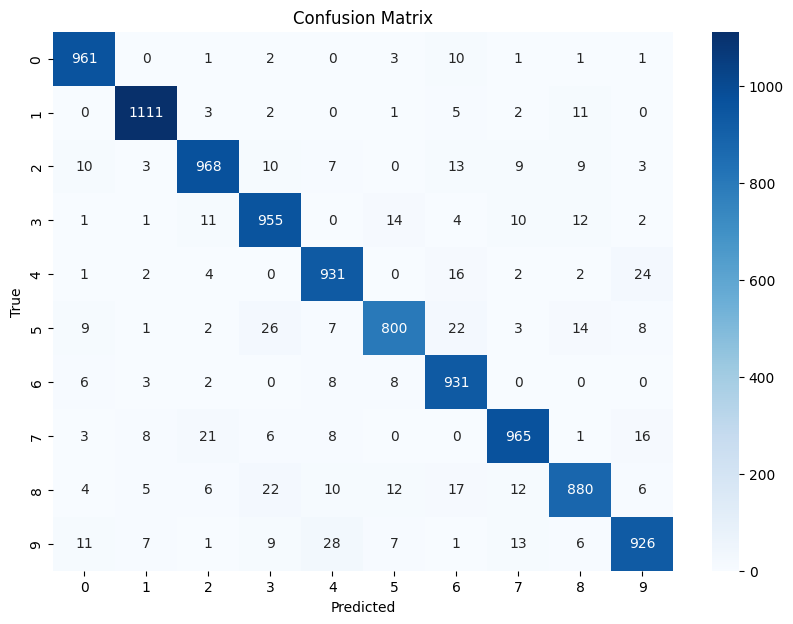

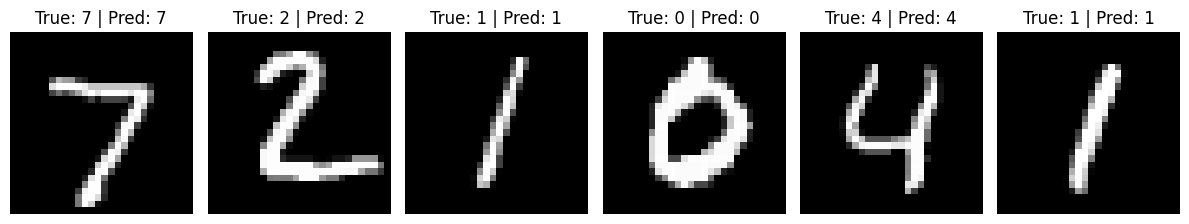

In [34]:
test(model_10, test_loader)

* At batch size = **32** --- Accuracy = **97.56%**
* At batch size = **64** --- Accuracy = **97.87%**
* At batch size = **128** --- Accuracy = **97.47%**
* At batch size = **256** --- Accuracy = **96.40%**
* At batch size = **512** --- Accuracy = **94.28%**

Then we choose batch size = **64** which is model_7 as it gives the highest accuracy

# Change number of neurons and layers  
* Learning rate = 0.1
* Batch size = 64

In [47]:
batch_size = 64

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Two Layers with 128 and 64 Neurons

Epoch [1/10]
Training Loss: 0.5606, Accuracy: 83.94%
Validation Loss: 0.2577, Accuracy: 92.32%
Epoch [2/10]
Training Loss: 0.1992, Accuracy: 94.09%
Validation Loss: 0.1608, Accuracy: 95.28%
Epoch [3/10]
Training Loss: 0.1346, Accuracy: 96.09%
Validation Loss: 0.1191, Accuracy: 96.35%
Epoch [4/10]
Training Loss: 0.1024, Accuracy: 96.96%
Validation Loss: 0.0932, Accuracy: 96.99%
Epoch [5/10]
Training Loss: 0.0837, Accuracy: 97.47%
Validation Loss: 0.0739, Accuracy: 97.82%
Epoch [6/10]
Training Loss: 0.0685, Accuracy: 97.94%
Validation Loss: 0.0606, Accuracy: 98.32%
Epoch [7/10]
Training Loss: 0.0568, Accuracy: 98.29%
Validation Loss: 0.0489, Accuracy: 98.70%
Epoch [8/10]
Training Loss: 0.0488, Accuracy: 98.48%
Validation Loss: 0.0403, Accuracy: 98.99%
Epoch [9/10]
Training Loss: 0.0402, Accuracy: 98.79%
Validation Loss: 0.0336, Accuracy: 99.15%
Epoch [10/10]
Training Loss: 0.0345, Accuracy: 98.99%
Validation Loss: 0.0278, Accuracy: 99.31%


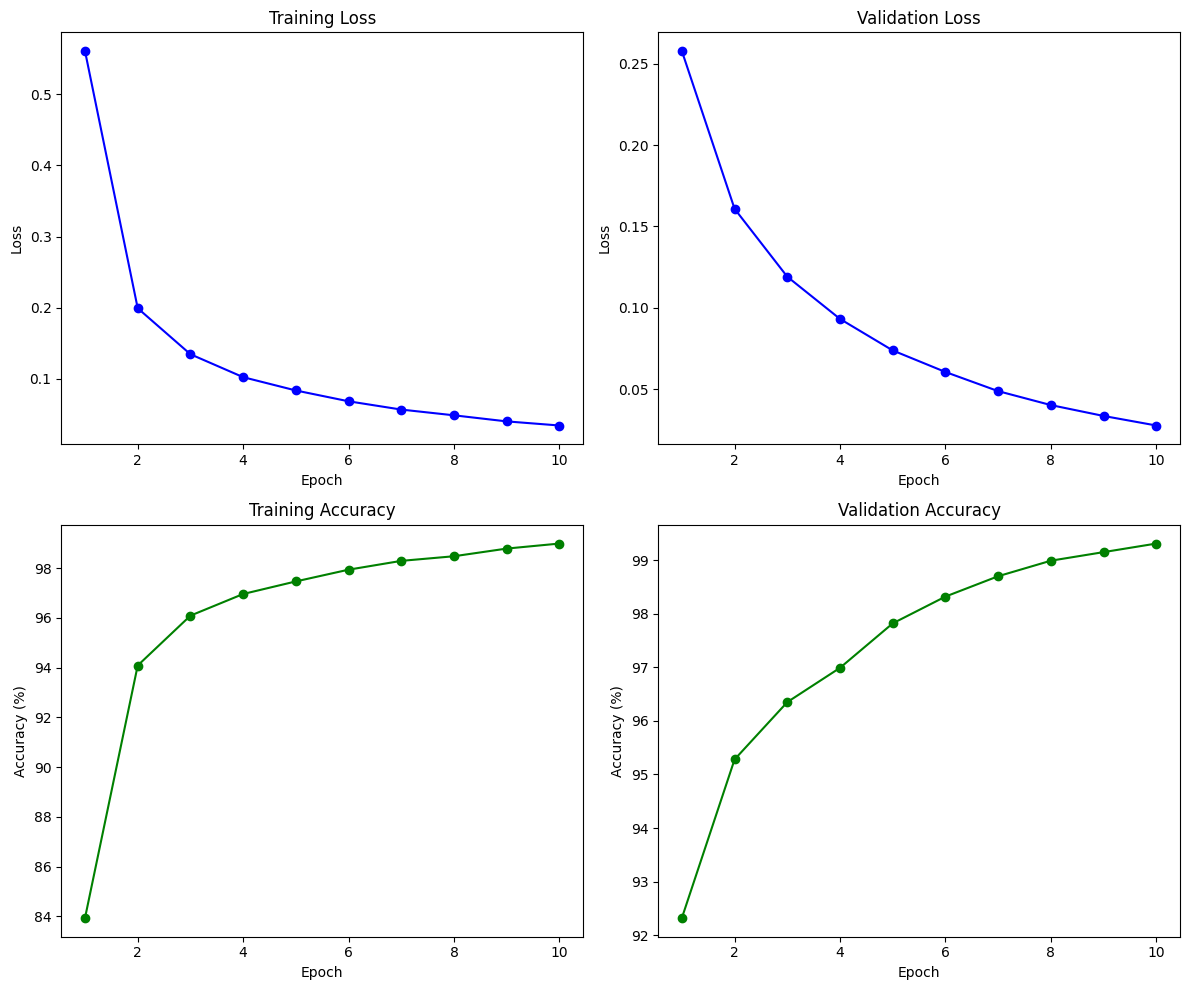

In [48]:
class FeedforwardNN_1(nn.Module):
    def __init__(self):
        super(FeedforwardNN_1, self).__init__()

        # Two layers with 128 and 64 neurons
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x

model_11 = FeedforwardNN_1()
loss_fn_11 = nn.CrossEntropyLoss()
optimizer_11 = optim.SGD(model_11.parameters(), lr=0.1)

train(model_11, train_loader, val_loader, loss_fn_11, optimizer_11, 10)

Test Accuracy: 97.85%


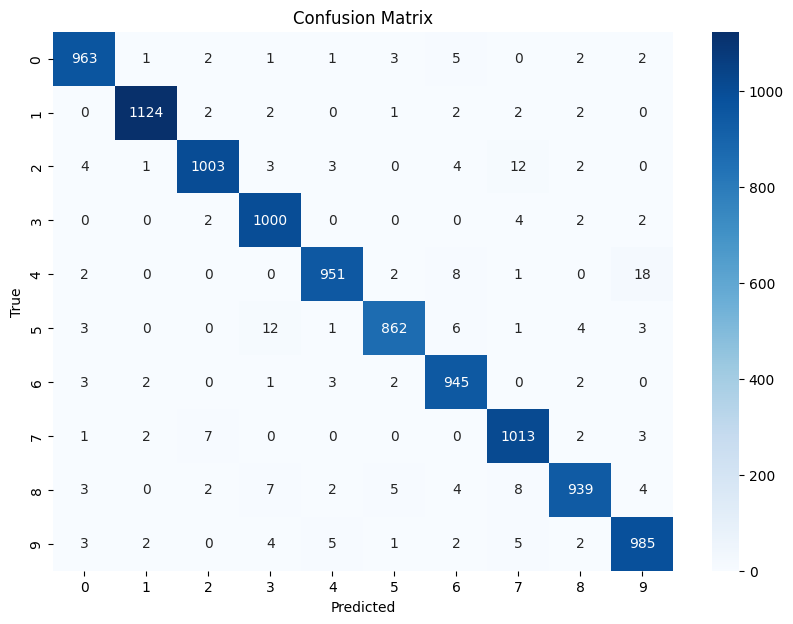

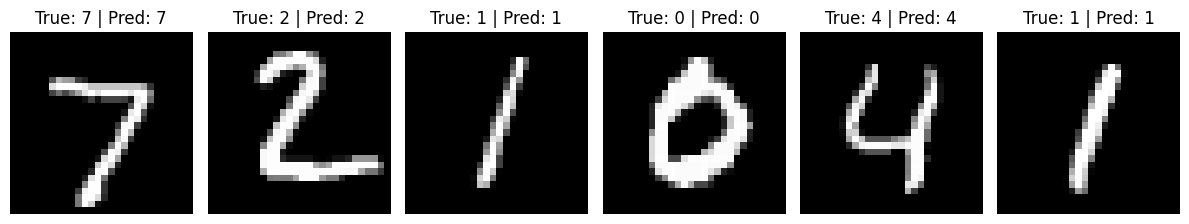

In [49]:
test(model_11, test_loader)

Three Layers with 512, 256, and 128 Neurons

Epoch [1/10]
Training Loss: 0.6847, Accuracy: 79.19%
Validation Loss: 0.2267, Accuracy: 93.35%
Epoch [2/10]
Training Loss: 0.1651, Accuracy: 95.04%
Validation Loss: 0.1246, Accuracy: 96.19%
Epoch [3/10]
Training Loss: 0.1036, Accuracy: 96.87%
Validation Loss: 0.0851, Accuracy: 97.50%
Epoch [4/10]
Training Loss: 0.0742, Accuracy: 97.76%
Validation Loss: 0.0638, Accuracy: 98.09%
Epoch [5/10]
Training Loss: 0.0558, Accuracy: 98.29%
Validation Loss: 0.0479, Accuracy: 98.67%
Epoch [6/10]
Training Loss: 0.0425, Accuracy: 98.74%
Validation Loss: 0.0349, Accuracy: 99.13%
Epoch [7/10]
Training Loss: 0.0348, Accuracy: 98.91%
Validation Loss: 0.0243, Accuracy: 99.42%
Epoch [8/10]
Training Loss: 0.0241, Accuracy: 99.28%
Validation Loss: 0.0184, Accuracy: 99.61%
Epoch [9/10]
Training Loss: 0.0180, Accuracy: 99.47%
Validation Loss: 0.0163, Accuracy: 99.60%
Epoch [10/10]
Training Loss: 0.0144, Accuracy: 99.60%
Validation Loss: 0.0110, Accuracy: 99.71%


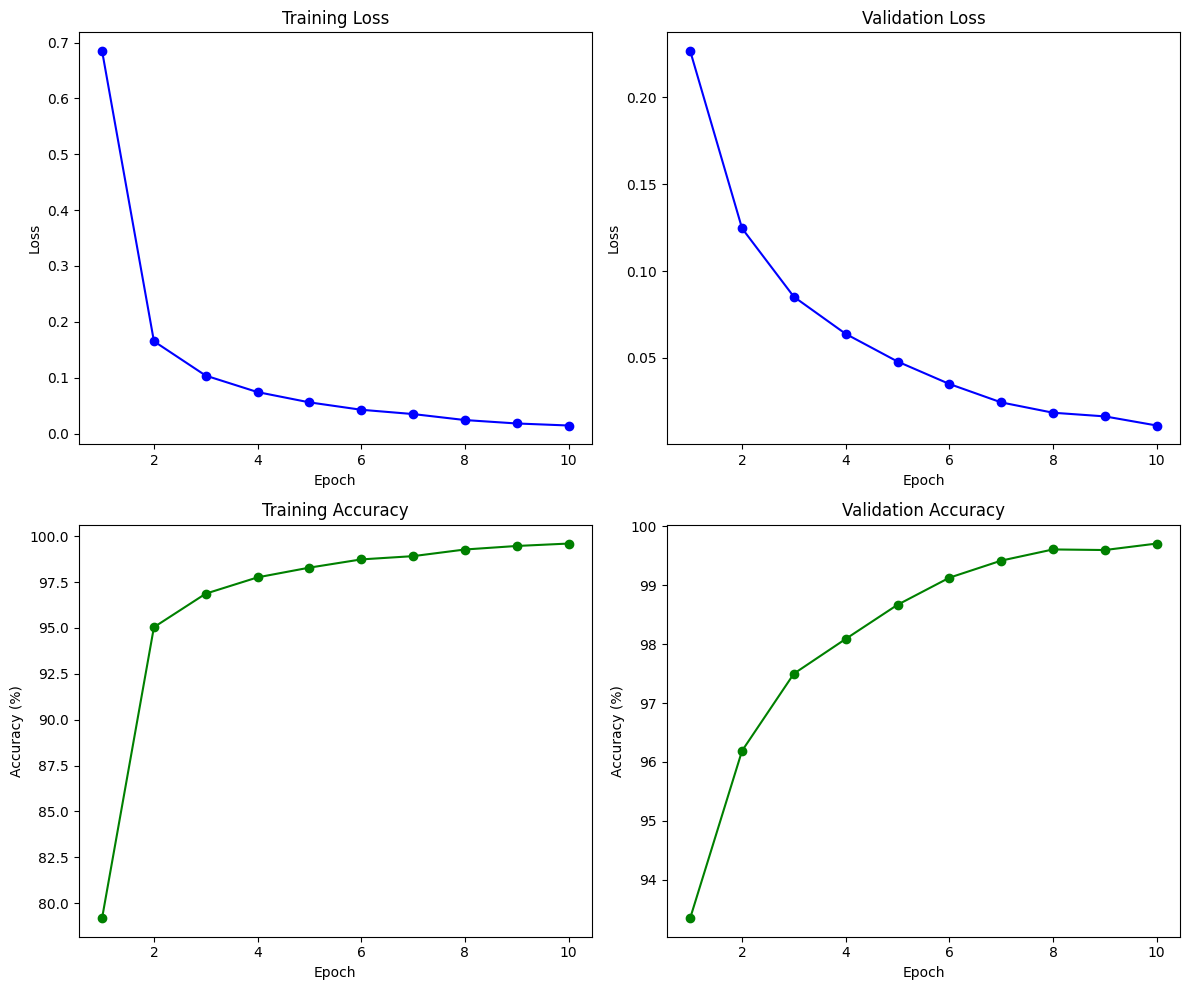

In [50]:
class FeedforwardNN_2(nn.Module):
    def __init__(self):
        super(FeedforwardNN_2, self).__init__()

        # Three layers with 512, 256, and 128 neurons
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.output(x)
        return x

model_12 = FeedforwardNN_2()
loss_fn_12 = nn.CrossEntropyLoss()
optimizer_12 = optim.SGD(model_12.parameters(), lr=0.1)

train(model_12, train_loader, val_loader, loss_fn_12, optimizer_12, 10)

Test Accuracy: 98.21%


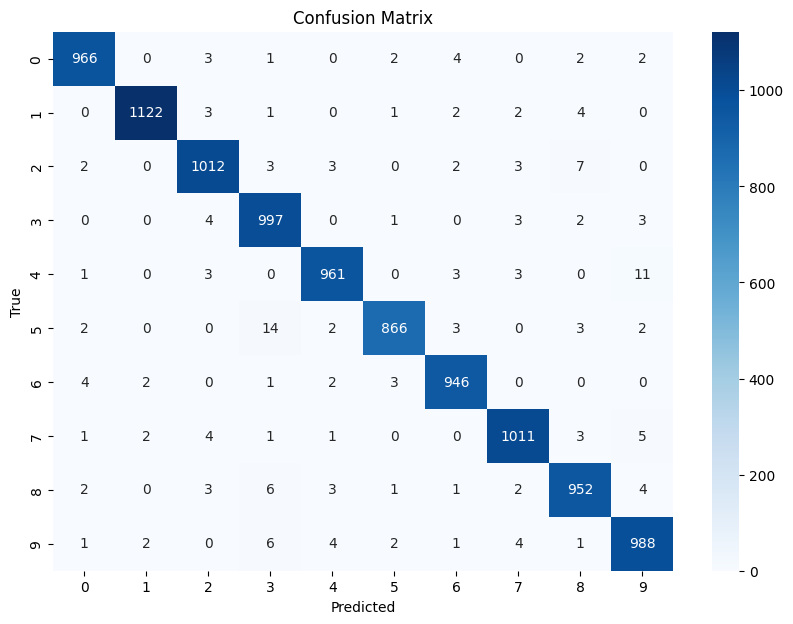

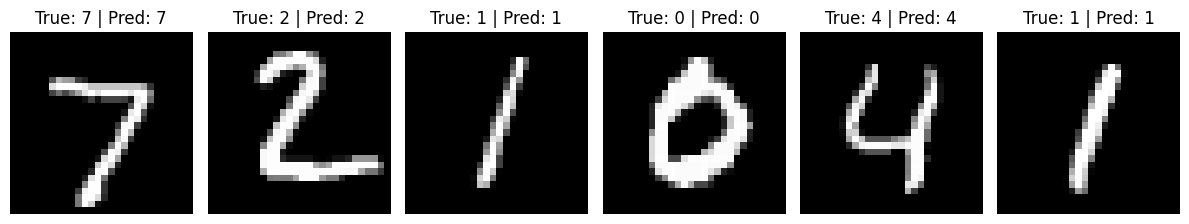

In [51]:
test(model_12, test_loader)

Four Layers with 512, 256, 128, and 64 Neurons

Epoch [1/10]
Training Loss: 0.9639, Accuracy: 66.95%
Validation Loss: 0.2273, Accuracy: 93.19%
Epoch [2/10]
Training Loss: 0.1634, Accuracy: 95.02%
Validation Loss: 0.1206, Accuracy: 96.27%
Epoch [3/10]
Training Loss: 0.0993, Accuracy: 97.05%
Validation Loss: 0.0814, Accuracy: 97.50%
Epoch [4/10]
Training Loss: 0.0716, Accuracy: 97.85%
Validation Loss: 0.0578, Accuracy: 98.24%
Epoch [5/10]
Training Loss: 0.0524, Accuracy: 98.39%
Validation Loss: 0.0417, Accuracy: 98.83%
Epoch [6/10]
Training Loss: 0.0400, Accuracy: 98.81%
Validation Loss: 0.0546, Accuracy: 98.47%
Epoch [7/10]
Training Loss: 0.0315, Accuracy: 98.98%
Validation Loss: 0.0244, Accuracy: 99.36%
Epoch [8/10]
Training Loss: 0.0233, Accuracy: 99.24%
Validation Loss: 0.0189, Accuracy: 99.44%
Epoch [9/10]
Training Loss: 0.0176, Accuracy: 99.46%
Validation Loss: 0.0137, Accuracy: 99.66%
Epoch [10/10]
Training Loss: 0.0150, Accuracy: 99.54%
Validation Loss: 0.0109, Accuracy: 99.72%


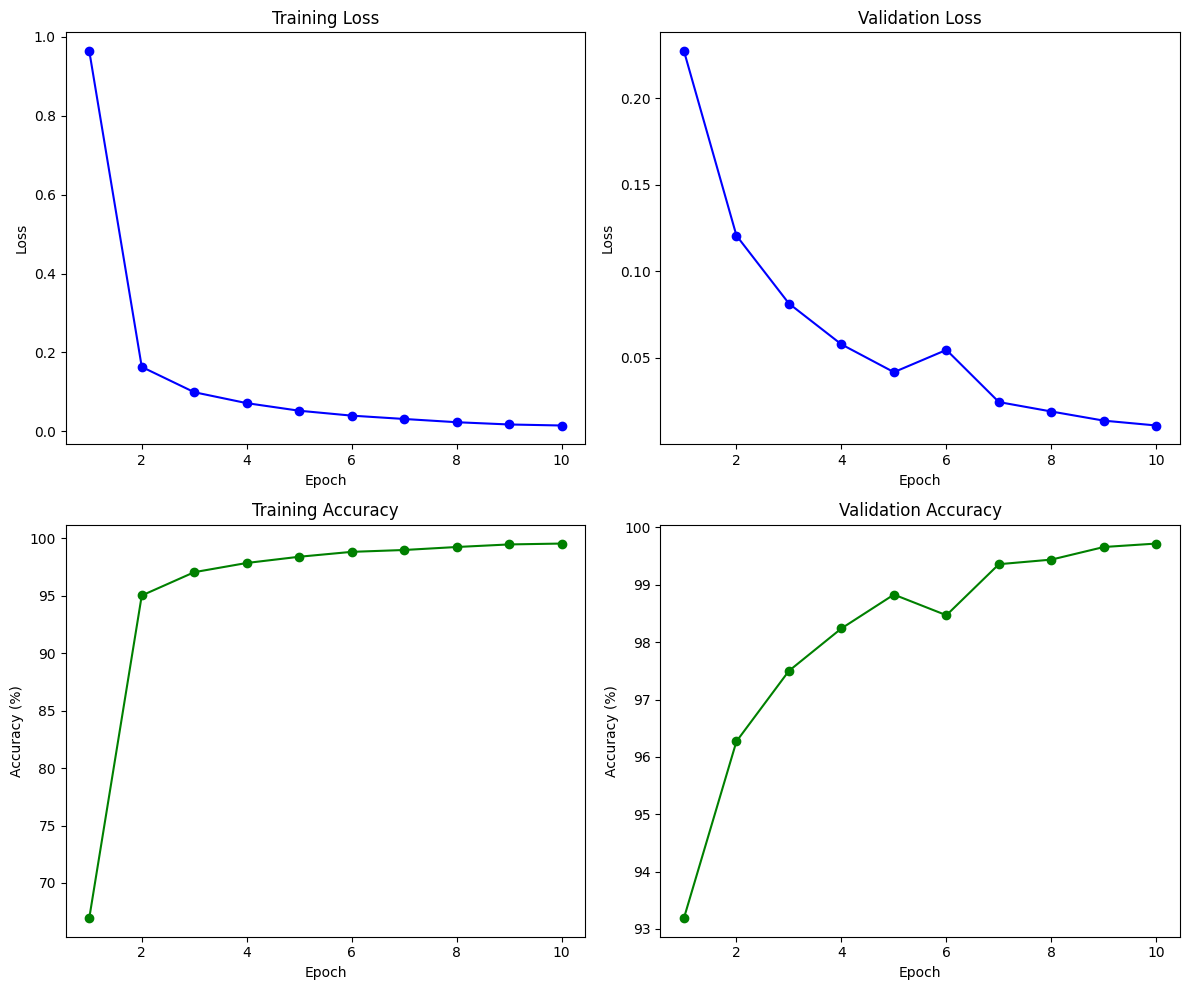

In [52]:
class FeedforwardNN_3(nn.Module):
    def __init__(self):
        super(FeedforwardNN_3, self).__init__()

        # Four layers with 512, 256, 128, and 64 neurons
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.activation_fn(self.l4(x))
        x = self.output(x)
        return x


model_13 = FeedforwardNN_3()
loss_fn_13 = nn.CrossEntropyLoss()
optimizer_13 = optim.SGD(model_13.parameters(), lr=0.1)

train(model_13, train_loader, val_loader, loss_fn_13, optimizer_13, 10)

Test Accuracy: 98.04%


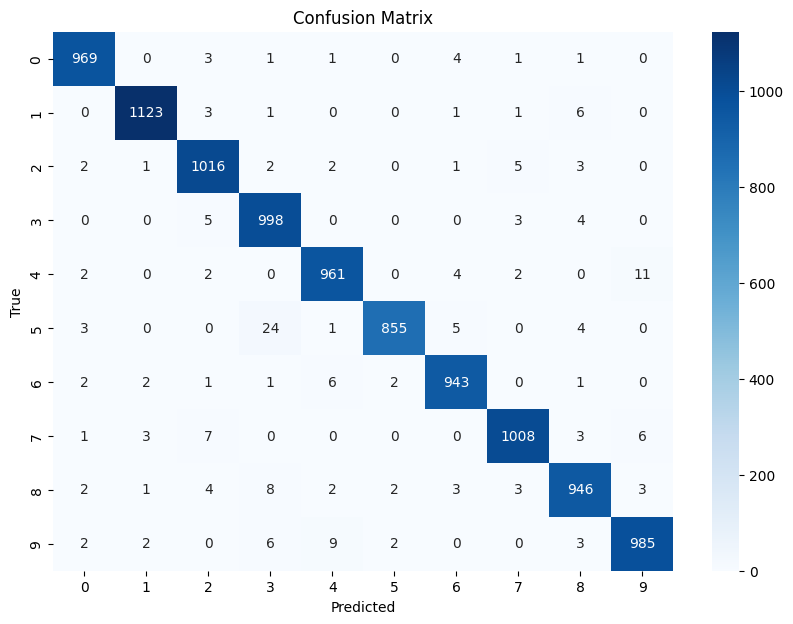

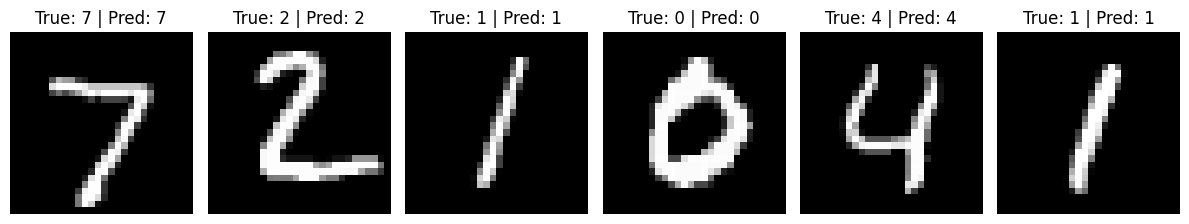

In [53]:
test(model_13, test_loader)

One Layer with 512 Neurons

Epoch [1/10]
Training Loss: 0.4603, Accuracy: 87.61%
Validation Loss: 0.2688, Accuracy: 92.35%
Epoch [2/10]
Training Loss: 0.2164, Accuracy: 93.83%
Validation Loss: 0.1843, Accuracy: 94.77%
Epoch [3/10]
Training Loss: 0.1560, Accuracy: 95.64%
Validation Loss: 0.1418, Accuracy: 96.00%
Epoch [4/10]
Training Loss: 0.1220, Accuracy: 96.59%
Validation Loss: 0.1148, Accuracy: 96.73%
Epoch [5/10]
Training Loss: 0.1005, Accuracy: 97.18%
Validation Loss: 0.0960, Accuracy: 97.31%
Epoch [6/10]
Training Loss: 0.0851, Accuracy: 97.60%
Validation Loss: 0.0819, Accuracy: 97.70%
Epoch [7/10]
Training Loss: 0.0738, Accuracy: 97.93%
Validation Loss: 0.0716, Accuracy: 98.05%
Epoch [8/10]
Training Loss: 0.0644, Accuracy: 98.20%
Validation Loss: 0.0632, Accuracy: 98.25%
Epoch [9/10]
Training Loss: 0.0571, Accuracy: 98.44%
Validation Loss: 0.0561, Accuracy: 98.49%
Epoch [10/10]
Training Loss: 0.0507, Accuracy: 98.61%
Validation Loss: 0.0501, Accuracy: 98.85%


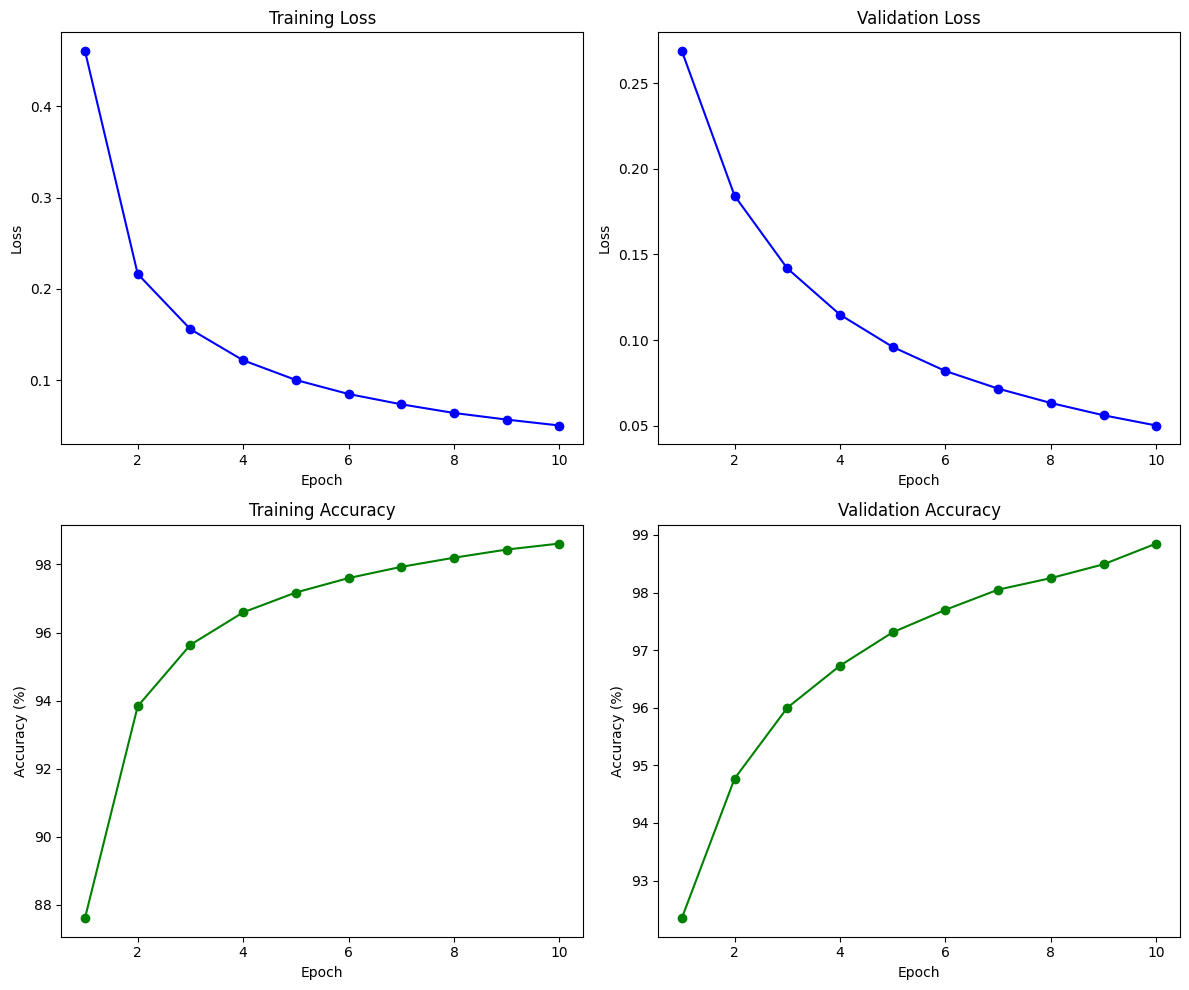

In [54]:
class FeedforwardNN_4(nn.Module):
    def __init__(self):
        super(FeedforwardNN_4, self).__init__()

        # One layer with 512 neurons
        self.l1 = nn.Linear(784, 512)
        self.output = nn.Linear(512, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.output(x)
        return x


model_14 = FeedforwardNN_4()
loss_fn_14 = nn.CrossEntropyLoss()
optimizer_14 = optim.SGD(model_14.parameters(), lr=0.1)

train(model_14, train_loader, val_loader, loss_fn_14, optimizer_14, 10)

Test Accuracy: 97.84%


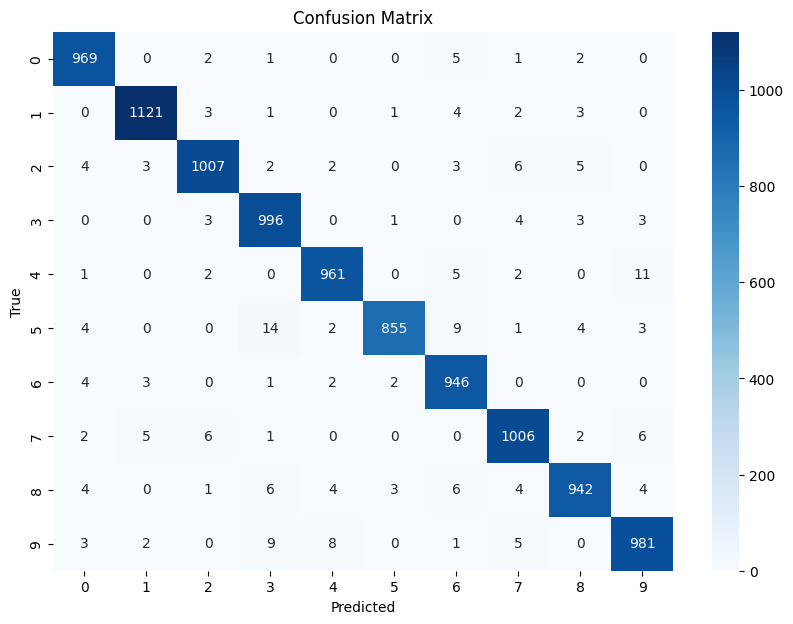

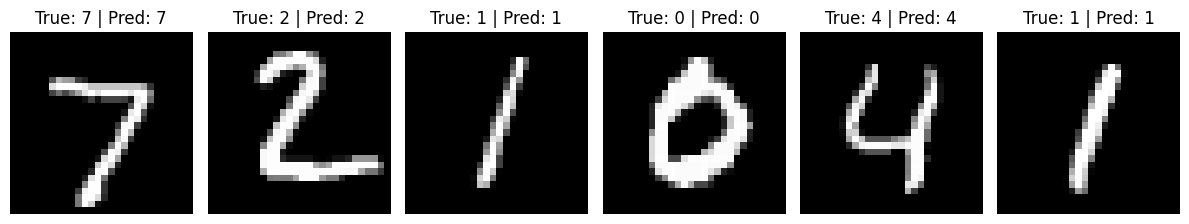

In [55]:
test(model_14, test_loader)

Two Layers with 256 and 128 Neurons

Epoch [1/10]
Training Loss: 0.5280, Accuracy: 85.10%
Validation Loss: 0.2450, Accuracy: 93.07%
Epoch [2/10]
Training Loss: 0.1878, Accuracy: 94.47%
Validation Loss: 0.1525, Accuracy: 95.46%
Epoch [3/10]
Training Loss: 0.1256, Accuracy: 96.28%
Validation Loss: 0.1103, Accuracy: 96.72%
Epoch [4/10]
Training Loss: 0.0933, Accuracy: 97.20%
Validation Loss: 0.0830, Accuracy: 97.60%
Epoch [5/10]
Training Loss: 0.0729, Accuracy: 97.83%
Validation Loss: 0.0644, Accuracy: 98.21%
Epoch [6/10]
Training Loss: 0.0603, Accuracy: 98.16%
Validation Loss: 0.0529, Accuracy: 98.58%
Epoch [7/10]
Training Loss: 0.0495, Accuracy: 98.49%
Validation Loss: 0.0423, Accuracy: 98.90%
Epoch [8/10]
Training Loss: 0.0402, Accuracy: 98.80%
Validation Loss: 0.0334, Accuracy: 99.26%
Epoch [9/10]
Training Loss: 0.0332, Accuracy: 98.98%
Validation Loss: 0.0272, Accuracy: 99.33%
Epoch [10/10]
Training Loss: 0.0273, Accuracy: 99.20%
Validation Loss: 0.0221, Accuracy: 99.63%


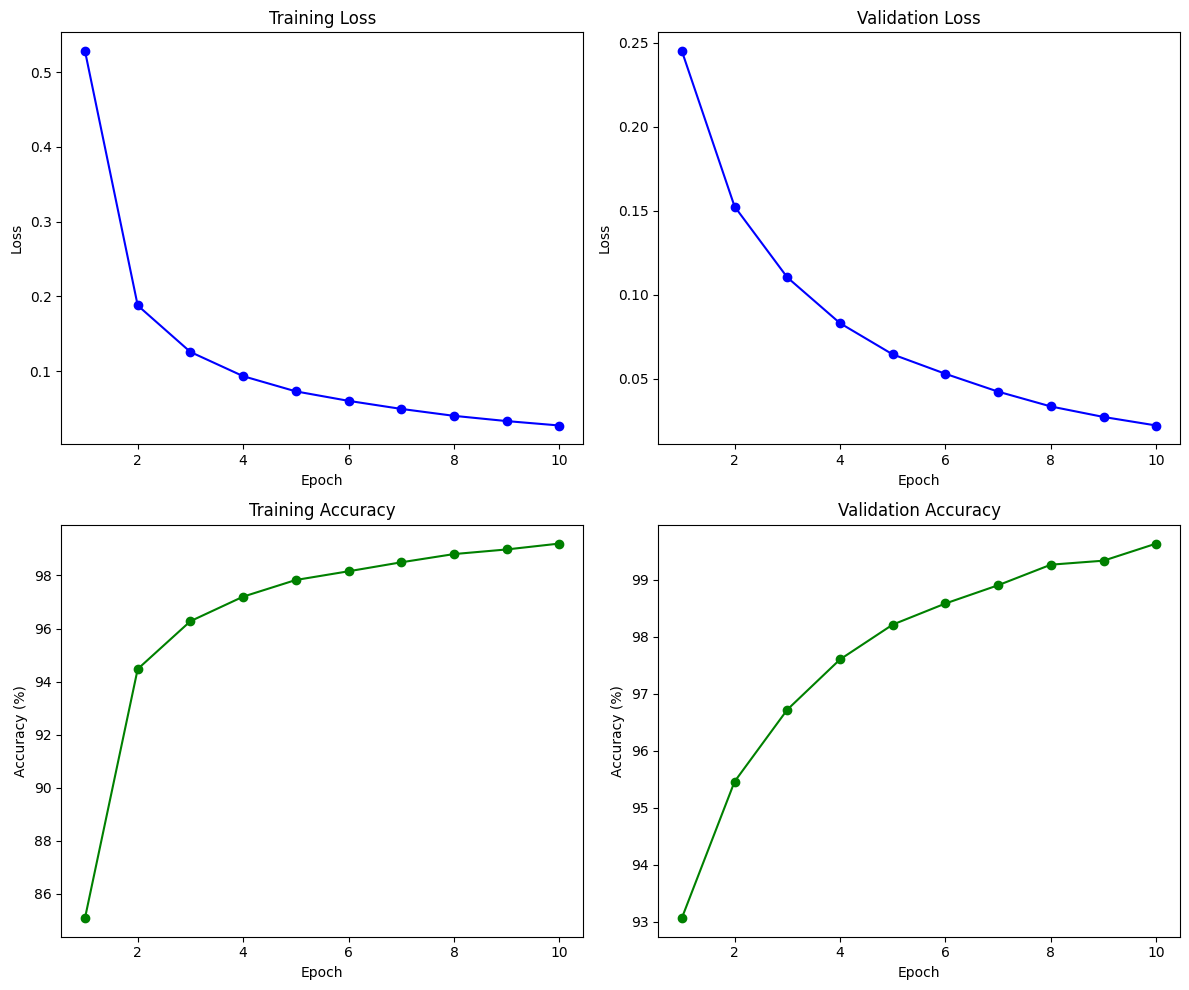

In [56]:
class FeedforwardNN_5(nn.Module):
    def __init__(self):
        super(FeedforwardNN_5, self).__init__()

        # Two layers with 256 and 128 neurons
        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_15 = FeedforwardNN_5()
loss_fn_15 = nn.CrossEntropyLoss()
optimizer_15 = optim.SGD(model_15.parameters(), lr=0.1)

train(model_15, train_loader, val_loader, loss_fn_15, optimizer_15, 10)

Test Accuracy: 98.03%


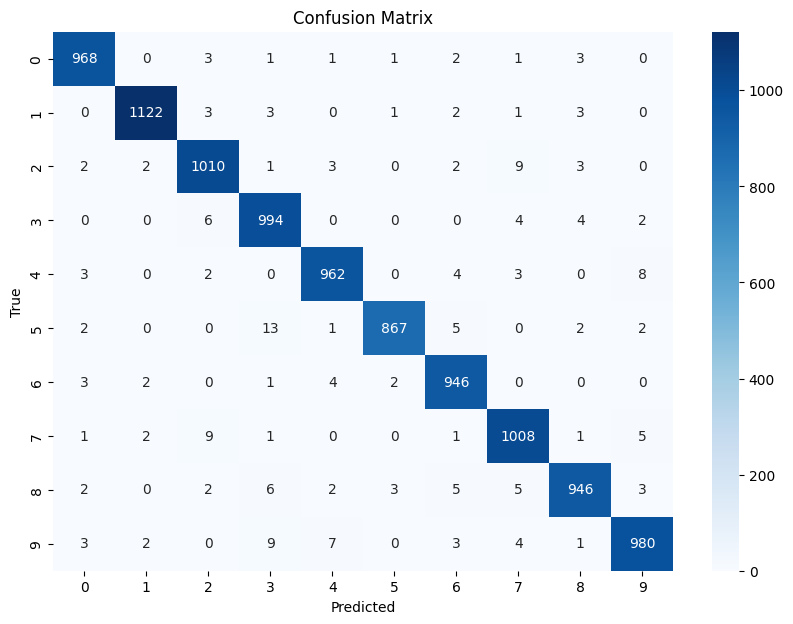

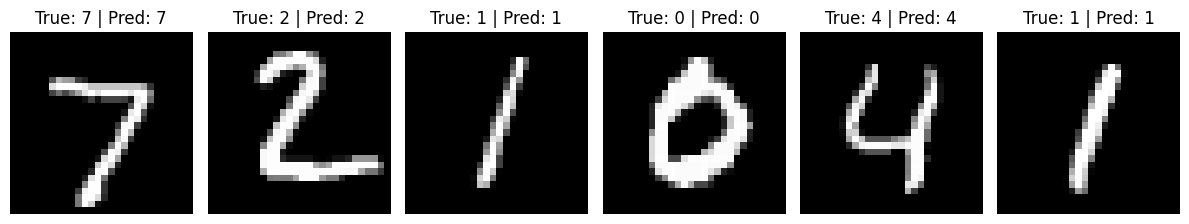

In [57]:
test(model_15, test_loader)

* At two layers with 128 and 64 Neurons --- Accuracy = **97.85%**
* At three layers with 512, 256, and 128 Neurons
 --- Accuracy = **98.21%**
* At four layers with 512, 256, 128, and 64 Neurons --- Accuracy = **98.04%**
* At one layer with 512 Neurons --- Accuracy = **97.84%**
* At two Layers with 256 and 128 Neurons --- Accuracy = **98.03%**

Then we choose at three layers with 512, 256, and 128 Neurons which is model_12 as it gives the highest accuracy

# Test of best found model on the test set
* Learning Rate = 0.1
* Batch Size = 64
* At three layers with 512, 256, and 128 Neurons

Test Accuracy: 98.21%


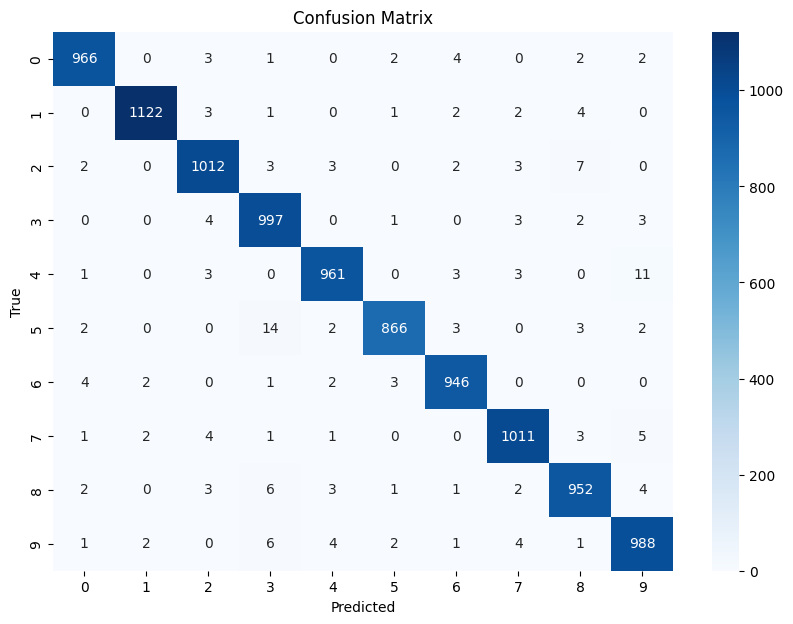

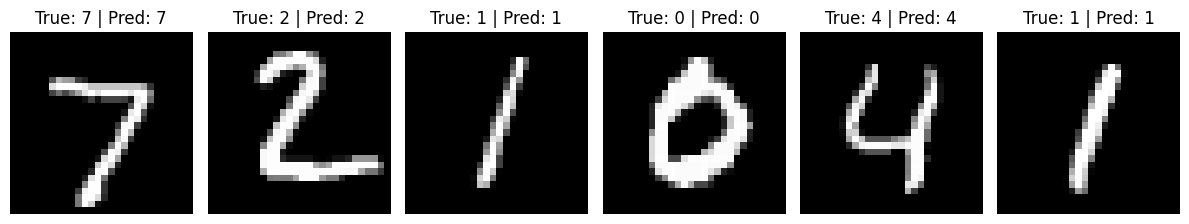

In [58]:
test(model_12, test_loader)